In [1]:
import pandas as pd
from orbit.models import ETS
from orbit.models import DLT
from orbit.diagnostics.backtest import BackTester
from orbit.models import KTR
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from math import sqrt
from concurrent.futures import ThreadPoolExecutor
import concurrent
import json
from typing import Any, Callable, Dict, Tuple
import itertools
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent

if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "Close"
df = pd.read_csv(file_path)
df = df.groupby(date_column).sum().reset_index()
df = df.dropna()
df[date_column] = pd.to_datetime(df.pop(date_column), format="%Y-%m-%d")
# df.set_index(date_time, inplace=True, drop=False)

data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

In [10]:
def evaluate_grid(
    model_function: Callable[[Dict[str, Any], str, str], Any],
    grid: Dict[str, Any],
    train: pd.DataFrame,
    date_column: str,
    target_column: str,
) -> Tuple[Dict[str, Any], float]:
    """
    Evaluate a forecasting model on a given parameter grid.

    This function uses a model creation function to initialize a model with the provided
    grid of parameters, performs backtesting using the provided training data, and computes
    the root mean squared error (RMSE) of the predictions.

    Parameters:
    - model_function (Callable[[Dict[str, Any], str, str], Any]): A function that creates
      a model instance. It should accept a parameter grid, a date column name, and a target
      column name.
    - grid (Dict[str, Any]): A dictionary containing the parameters for the model.
    - train (pd.DataFrame): The training dataset as a Pandas DataFrame.
    - date_column (str): The name of the column in 'train' that contains the date information.
    - target_column (str): The name of the target column in 'train'.

    Returns:
    - Tuple[Dict[str, Any], float]: A tuple containing the grid of parameters and the
      corresponding RMSE score.
    """
    model = model_function(grid, date_column, target_column)

    bt = BackTester(
        df=train, model=model, forecast_len=90, n_splits=5, window_type="rolling"
    )

    bt.fit_predict()
    predicted_df = bt.get_predicted_df()

    score = sqrt(mean_squared_error(predicted_df["actual"], predicted_df["prediction"]))
    return grid, score

In [4]:
param_grid = {
    "seasonality": [None, 90, 180, 360],
    "level_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
    "seasonality_sm_input": [None, 0, 0.3, 0.5, 0.8, 1],
}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [5]:
ets_scores = dict()


def ets_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an ETS model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the ETS model configured with the given parameters.
    """
    return ETS(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        seed=1,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, ets_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        ets_scores[json.dumps(option)] = score

2024-04-01 15:46:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:46:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:46:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:46:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














































































































































































































chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)





















chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)


















chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)
























































































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     








chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     



























chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     













chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2024-04-01 15:47:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:47:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status




















2024-04-01 15:47:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































2024-04-01 15:47:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)








































































































2024-04-01 15:47:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     




































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     














chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     















chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     



chain 1 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)

2024-04-01 15:47:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)
2024-04-01 15:47:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     


chain 4 |          | 00:00 Status










chain 4 |██▌       | 00:00 Status






















2024-04-01 15:47:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 4 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)











2024-04-01 15:47:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































chain 4 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)





















chain 4 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)




































































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed        

chain 4 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)



























































2024-04-01 15:47:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     




chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status



































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 4 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)



































































2024-04-01 15:47:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 4 |█████     | 00:02 Iteration:   1 / 250 [  0%]  (Warmup)















chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     


2024-04-01 15:47:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 4 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 4 |          | 00:04 Iteration: 226 / 250 [ 90%]  (Sampling)


















2024-04-01 15:47:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     


















































































































































2024-04-01 15:47:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     









































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     













chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

















chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:03 Iteration: 200 / 250 [ 80%]  (Warmup)2024-04-01 15:47:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     

chain 3 |██▌       | 00:00 Status

2024-04-01 15:47:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:47:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























































































2024-04-01 15:47:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling c











































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)



































chain 1 |          | 00:06 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-01 15:47:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































chain 1 |██████████| 00:08 Sampling completed                     
chain 2 |██████████| 00:08 Sampling completed                     
chain 3 |██████████| 00:08 Sampling completed                     
chain 4 |██████████| 00:08 Sampling completed                     









































































2024-04-01 15:47:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     







































































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     































chain 1 |██████████| 00:10 Sampling completed                     
chain 2 |██████████| 00:10 Sampling completed                     
chain 3 |██████████| 00:10 Sampling completed                     
chain 4 |██████████| 00:10 Sampling completed                     









chain 4 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     


chain 4 |██████████| 00:01 Sampling completed                     

2024-04-01 15:47:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


2024-04-01 15:47:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 15:47:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:47:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)















































































































































2024-04-01 15:47:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


















2024-04-01 15:47:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)



















































chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)




























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     















































































































































































2024-04-01 15:48:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     
chain 3 |██████████| 00:09 Sampling completed                     
chain 4 |██████████| 00:09 Sampling completed                     














chain 1 |          | 00:00 Status











chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     













chain 1 |██████████| 00:09 Sampling completed                     
chain 2 |██████████| 00:09 Sampling completed                     


chain 3 |██████████| 00:09 Sampling completed                     

chain 4 |██████████| 00:09 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-04-01 15:48:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:48:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



2024-04-01 15:48:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |██▌       | 00:00 Status






























2024-04-01 15:48:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     


chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 4 |███████▌  | 00:03 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |██████████| 00:04 Iteration: 200 / 250 [ 80%]  (Warmup)

























chain 1 |          | 00:05 Iteration: 226 / 250 [ 90%]  (Sampling)










































2024-04-01 15:48:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















2024-04-01 15:48:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     



chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     













































































































































































































































chain 1 |██████████| 00:02 Sampling completed                     













chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     














chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:48:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2024-04-01 15:48:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















2024-04-01 15:48:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:48:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 4 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)































































2024-04-01 15:48:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |██████████| 00:05 Sampling completed                     
chain 2 |██████████| 00:05 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     

chain 1 |          | 00:00 Status









chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

chain 2 |██▌       | 00:00 Status

chain 1 |██▌       | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

2024-04-01 15:48:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

















chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     
















chain 4 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)












































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:48:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:48:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















chain 1 |██▌       | 00:00 Status




2024-04-01 15:48:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































2024-04-01 15:48:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 3 |███████▌  | 00:04 Iteration: 100 / 250 [ 40%]  (Warmup)























































































chain 1 |███████▌  | 00:05 Iteration: 100 / 250 [ 40%]  (Warmup)















































chain 1 |██████████| 00:05 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     













chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:05 Sampling completed                     
chain 4 |██████████| 00:05 Sampling completed                     







chain 1 |██████████| 00:06 Sampling completed                     
chain 2 |██████████| 00:06 Sampling completed                     
chain 3 |██████████| 00:06 Sampling completed                     
chain 4 |██████████| 00:06 Sampling completed                     

2024-04-01 15:48:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 15:48:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)


2024-04-01 15:48:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































2024-04-01 15:48:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |       

chain 3 |██▌       | 00:00 Status

chain 2 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)





























































































































































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     









chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     






































chain 3 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:48:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     

2024-04-01 15:48:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:48:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:48:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status




























































































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 15:48:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 1 |██████████| 00:03 Sampling completed                     











chain 3 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     


chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 4 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)



















































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:48:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-01 15:48:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












2024-04-01 15:48:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:48:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)


































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 4 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     













chain 1 |██████████| 00:02 Sampling completed                     


chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


2024-04-01 15:49:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:49:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:49:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:49:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































































































































































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)



















































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     











chain 1 |██████████| 00:02 Sampling completed                     
chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 4 |██████████| 00:02 Sampling completed                     


2024-04-01 15:49:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status2024-04-01 15:49:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
2024-04-01 15:49:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














2024-04-01 15:49:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)
































































chai






































































































chain 1 |██████████| 00:02 Sampling completed                     











chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     



















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     











chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:49:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-01 15:49:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







2024-04-01 15:49:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 15:49:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 
























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     













chain 3 |██████████| 00:02 Sampling completed                     


chain 4 |██████████| 00:02 Sampling completed                     














chain 2 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 4 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                     


chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:49:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-01 15:49:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:49:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












2024-04-01 15:49:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





























































































































































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 2 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     





















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     





















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:49:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-01 15:49:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)res: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.2024-04-01 15:49:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)








































chain 1 |██████████| 00:01 Iterat

chain 3 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)







































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     














chain 1 |██████████| 00:03 Sampling completed                     












chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     


chain 3 |██████████| 00:03 Sampling completed                     


chain 4 |██████████| 00:03 Sampling completed                     

2024-04-01 15:49:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)


2024-04-01 15:49:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:49:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:49:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |          | 00:00 Status

















chain 1 |██▌       | 00:00 Status

























































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)























































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     












chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)











































2024-04-01 15:49:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     







chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     













































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:49:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)
2024-04-01 15:49:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:49:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)






































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:0


















































































2024-04-01 15:49:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     



chain 1 |██████████| 00:02 Sampling completed                     2024-04-01 15:49:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)
chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:49:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-04-01 15:49:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































2024-04-01 15:49:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)























































































































































chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)






































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)
















































2024-04-01 15:49:53 - orbit 


chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     





































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:49:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status2024-04-01 15:49:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










2024-04-01 15:49:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)

2024-04-01 15:50:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     





















chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     












chain 4 |██████████| 00:04 Sampling completed                     

chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


2024-04-01 15:50:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
2024-04-01 15:50:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


2024-04-01 15:50:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















2024-04-01 15:50:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40
































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     











chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


2024-04-01 15:50:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)

2024-04-01 15:50:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 4 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 15:50:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



2024-04-01 15:50:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampli


















































































































































































































































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

















































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     














chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-01 15:50:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:50:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 15:50:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:50:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)






























































































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)


















































































2024-04-01 15:50:27 - orbit - INFO - Sampling (Py























































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     




























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     








































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:50:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



2024-04-01 15:50:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)














2024-04-01 15:50:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed               

chain 4 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)























2024-04-01 15:50:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















































































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






























































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 4 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)s: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     





















































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:50:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



2024-04-01 15:50:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)




































chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:50:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status

























chain 1 |██▌       | 00:00 Status








chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 15:50:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)






























chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed            





chain 4 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)

















2024-04-01 15:50:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     
























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     






chain 4 |██████████| 00:03 Sampling completed                     























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:50:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)
2024-04-01 15:50:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)


































2024-04-01 15:50:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























chain 1 |          | 00:03 Iteration: 226 / 250 [ 90%]  (Sampling)






















chain 1 |██████████| 00:03 Sampling completed                     









cha










chain 1 |██▌       | 00:00 Status

chain 3 |██▌       | 00:00 Status





















2024-04-01 15:50:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:00 Status











chain 1 |██▌       | 00:00 Status




































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     




chain 3 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 2 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)


























chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)




































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)





















chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     



chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:50:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)




2024-04-01 15:50:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)






































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


























2024-04-01 15:51:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:51:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |          | 00:00 Status









































chain 1 |██▌       | 00:00 Status














































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)























chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)


































2024-04-01 15:51:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 2 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)







































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:51:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)



2024-04-01 15:51:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 00:01 Sampling completed                     
chain 2 |██████████| 00:01 Sampling completed                     
chain 3 |██████████| 00:01 Sampling completed                     
chain 4 |██████████| 00:01 Sampling completed                     








chain 4 |██▌       | 00:00 Status













2024-04-01 15:51:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









chain 1 |          | 00:00 Status







chain 1 |██▌       | 00:00 Status











chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 15:51:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     





















chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)




















































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)


































2024-04-01 15:51:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |          | 00:00 Status


chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 1 |██▌       | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 15:51:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)




















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     
























2024-04-01 15:51:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status














chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

2024-04-01 15:51:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)






































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     






chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 3 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 3 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-01 15:51:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |          | 00:00 Status












chain 1 |██▌       | 00:00 Status


chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 15:51:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)







































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)





































2024-04-01 15:51:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)


































2024-04-01 15:51:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██▌       | 00:00 Status
























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




















































chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 4 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

2024-04-01 15:51:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:51:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 15:51:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























2024-04-01 15:51:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)































































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                  























2024-04-01 15:51:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























chain 1 |          | 00:00 Status


















chain 1 |██▌       | 00:00 Status










































































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 2 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |██████████| 00:02 Iteration: 200 / 250 [ 80%]  (Warmup)


2024-04-01 15:51:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     












chain 3 |██████████| 00:02 Sampling completed                     






chain 4 |██████████| 00:02 Sampling completed                     































































2024-04-01 15:51:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 15:51:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)
















2024-04-01 15:51:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)















































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |████████












chain 3 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 4 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)



































































2024-04-01 15:51:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status








chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     









chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     


chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:51:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




2024-04-01 15:51:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)





































2024-04-01 15:51:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)






























































































2024-04-01 15:51:46 - orbit - INFO - Sampling (PyStan) with 

chain 4 |          | 00:00 Status























chain 4 |██▌       | 00:00 Status











































































chain 4 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)












































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 3 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 4 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 4 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     















chain 2 |███████▌  | 00:02 Iteration: 100 / 250 [ 40%]  (Warmup)












2024-04-01 15:51:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















chain 4 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)























chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:51:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 15:51:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 2 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 15:51:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)















































chain 1 |██████████| 00:02 Sampling c









2024-04-01 15:51:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |          | 00:00 Status








chain 1 |██▌       | 00:00 Status



























































chain 1 |█████     | 00:01 Iteration:   1 / 250 [  0%]  (Warmup)




















chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     











chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:51:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:52:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 4 |██▌       | 00:00 Status2024-04-01 15:52:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 15:52:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)






























































































chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 4 |███████▌  | 00:02 Iterati












































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     





























































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

chain 4 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:52:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 15:52:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)


























2024-04-01 15:52:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




2024-04-01 15:52:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:02 Iteration: 226 / 250 [ 90%]  (Sampling)

















chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 3 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)


























































































































































































































































2024-04-01 15:52:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |          | 00:00 Status






chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     



chain 1 |██▌       | 00:00 Status














































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |██████████| 00:03 Sampling completed                     


chain 2 |██████████| 00:03 Sampling completed                     


chain 3 |██████████| 00:03 Sampling completed                     


chain 4 |██████████| 00:03 Sampling completed                     


chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:01 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

2024-04-01 15:52:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |█████     | 00:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 00:00 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:01 Iteration: 200 / 250 [ 80%]  (Warmup)
2024-04-01 15:52:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |██▌       | 00:00 Status2024-04-01 15:52:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














chain 1 |          | 00:01 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |█

2024-04-01 15:52:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |          | 00:00 Status









chain 1 |██▌       | 00:00 Status













































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     











2024-04-01 15:52:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     







chain 2 |██▌       | 00:00 Status

chain 3 |██▌       | 00:00 Status














































































2024-04-01 15:52:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




chain 1 |██████████| 00:02 Sampling completed                     
chain 2 |██████████| 00:02 Sampling completed                     
chain 3 |██████████| 00:02 Sampling completed                     
chain 4 |██████████| 00:02 Sampling completed                     

chain 1 |          | 00:00 Status


































2024-04-01 15:52:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































2024-04-01 15:52:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     
























































































2024-04-01 15:52:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampling completed                     























































































































chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-01 15:52:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































2024-04-01 15:52:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































































































































































































chain 1 |██████████| 00:04 Sampling completed                     
chain 2 |██████████| 00:04 Sampling completed                     
chain 3 |██████████| 00:04 Sampling completed                     
chain 4 |██████████| 00:04 Sampl


























chain 1 |██████████| 00:03 Sampling completed                     
chain 2 |██████████| 00:03 Sampling completed                     
chain 3 |██████████| 00:03 Sampling completed                     
chain 4 |██████████| 00:03 Sampling completed                     

2024-04-01 15:52:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2024-04-01 15:52:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |█████     | 02:44 Iteration:   1 / 250 [  0%]  (Warmup)









































































chain 1 |██████████| 02:48 Sampling completed                     
chain 2 |██████████| 02:48 Sampling completed                     
chain 3 |██████████| 02:48 Sampling completed                     
chain 4 |██████████| 02:48 Sampling completed                     














2024-04-01 15:55:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |███████▌  | 02:57 Iteration: 100 / 250 [ 40%]  (Warmup)






















chain 1 |██████████| 02:59 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |██████████| 03:01 Sampling completed                     
chain 2 |██████████| 03:01 Sampling completed                     
chain 3 |██████████| 03:01 Sampling completed                     
chain 4 |██████████| 03:01 Sampling completed                     





















































2024-04-01 15:55:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

















































































































































































chain 1 |██████████| 02:51 Sampling completed                     
chain 2 |██████████| 02:51 Sampling completed                     
chain 3 |██████████| 02:51 Sampling completed                     
chain 4 |██████████| 02:51 Sampling completed                     





















chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

2024-04-01 15:55:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2024-04-01 15:55:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































































chain 1 |██████████| 02:37 Sampling completed                     
chain 2 |██████████| 02:37 Sampling completed                     
chain 3 |██████████| 02:37 Sampling completed                     
chain 4 |██████████| 02:37 Sampling completed                     










2024-04-01 15:57:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |█████     | 02:31 Iteration:   1 / 250 [  0%]  (Warmup)























































chain 1 |██████████| 02:38 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |          | 02:41 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 02:41 Sampling completed                     
chain 2 |██████████| 02:41 Sampling completed                     
chain 3 |██████████| 02:41 Sampling completed                     
chain 4 |██████████| 02:41 Sampling completed                     

































2024-04-01 15:58:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





































































































































































chain 1 |██████████| 02:46 Sampling completed                     
chain 2 |██████████| 02:46 Sampling completed                     
chain 3 |██████████| 02:46 Sampling completed                     
chain 4 |██████████| 02:46 Sampling completed                     

2024-04-01 15:58:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































chain 1 |██████████| 02:58 Sampling completed                     
chain 2 |██████████| 02:58 Sampling completed                     
chain 3 |██████████| 02:58 Sampling completed                     
chain 4 |██████████| 02:58 Sampling completed                     

2024-04-01 15:58:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































chain 1 |██████████| 02:37 Sampling completed                     
chain 2 |██████████| 02:37 Sampling completed                     
chain 3 |██████████| 02:37 Sampling completed                     
chain 4 |██████████| 02:37 Sampling completed                     

chain 1 |█████     | 02:24 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 16:00:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |███████▌  | 02:35 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 02:38 Iteration: 226 / 250 [ 90%]  (Sampling)












































chain 1 |██████████| 02:50 Sampling completed                     











chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     












2024-04-01 16:01:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status































































































































































































































































chain 1 |██████████| 02:44 Sampling completed                     
chain 2 |██████████| 02:44 Sampling completed                     
chain 3 |██████████| 02:44 Sampling completed                     
chain 4 |██████████| 02:44 Sampling completed                     




























chain 1 |██████████| 02:56 Sampling completed                     
chain 2 |██████████| 02:56 Sampling completed                     
chain 3 |██████████| 02:56 Sampling completed                     
chain 4 |██████████| 02:56 Sampling completed                     

2024-04-01 16:01:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2024-04-01 16:01:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:33 Sampling completed                     
chain 2 |██████████| 02:33 Sampling completed                     
chain 3 |██████████| 02:33 Sampling completed                     
chain 4 |██████████| 02:33 Sampling completed                     

2024-04-01 16:03:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |█████     | 02:37 Iteration:   1 / 250 [  0%]  (Warmup)


























chain 1 |██████████| 02:45 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |          | 02:49 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 02:56 Sampling completed                     
chain 2 |██████████| 02:56 Sampling completed                     
chain 3 |██████████| 02:56 Sampling completed                     
chain 4 |██████████| 02:56 Sampling completed                     








































2024-04-01 16:04:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status








































































































































































































chain 1 |██████████| 02:43 Sampling completed                     
chain 2 |██████████| 02:43 Sampling completed                     
chain 3 |██████████| 02:43 Sampling completed                     
chain 4 |██████████| 02:43 Sampling completed                     

2024-04-01 16:04:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |██████████| 02:47 Sampling completed                     
chain 2 |██████████| 02:47 Sampling completed                     
chain 3 |██████████| 02:47 Sampling completed                     
chain 4 |██████████| 02:47 Sampling completed                     

2024-04-01 16:04:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampling completed                     

2024-04-01 16:05:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |█████     | 01:50 Iteration:   1 / 250 [  0%]  (Warmup)

























chain 1 |          | 01:58 Iteration: 226 / 250 [ 90%]  (Sampling)






















































































chain 1 |██████████| 02:01 Sampling completed                     
chain 2 |██████████| 02:01 Sampling completed                     
chain 3 |██████████| 02:01 Sampling completed                     
chain 4 |██████████| 02:01 Sampling completed                     

2024-04-01 16:06:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










chain 1 |██▌       | 00:00 Status

















































































































































chain 1 |██████████| 02:02 Sampling completed                     
chain 2 |██████████| 02:02 Sampling completed                     
chain 3 |██████████| 02:02 Sampling completed                     
chain 4 |██████████| 02:02 Sampling completed                     

2024-04-01 16:06:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































chain 1 |██████████| 02:05 Sampling completed                     
chain 2 |██████████| 02:05 Sampling completed                     
chain 3 |██████████| 02:05 Sampling completed                     
chain 4 |██████████| 02:05 Sampling completed                     

2024-04-01 16:06:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































































































chain 1 |██████████| 00:12 Sampling completed                     
chain 2 |██████████| 00:12 Sampling completed                     
chain 3 |██████████| 00:12 Sampling completed                     
chain 4 |██████████| 00:12 Sampling completed                     

2024-04-01 16:06:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-04-01 16:07:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































































chain 1 |██████████| 00:11 Sampling completed                     
chain 2 |██████████| 00:11 Sampling completed                     
chain 3 |██████████| 00:11 Sampling completed                     
chain 4 |██████████| 00:11 Sampling completed                     

2024-04-01 16:07:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































































































































































































































chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     























2024-04-01 16:07:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































































chain 1 |██████████| 02:02 Sampling completed                     
chain 2 |██████████| 02:02 Sampling completed                     
chain 3 |██████████| 02:02 Sampling completed                     
chain 4 |██████████| 02:02 Sampling completed                     










































chain 1 |██████████| 01:15 Sampling completed                     
chain 2 |██████████| 01:15 Sampling completed                     
chain 3 |██████████| 01:15 Sampling completed                     
chain 4 |██████████| 01:15 Sampling completed                     


2024-04-01 16:07:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































2024-04-01 16:07:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     

2024-04-01 16:07:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |██████████| 01:54 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 01:55 Iteration: 226 / 250 [ 90%]  (Sampling)










chain 1 |██████████| 02:05 Sampling completed                     
chain 2 |██████████| 02:05 Sampling completed                     
chain 3 |██████████| 02:05 Sampling completed                     
chain 4 |██████████| 02:05 Sampling completed                     

2024-04-01 16:08:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























































































































































































































































chain 1 |██████████| 00:59 Sampling completed                     
chain 2 |██████████| 00:59 Sampling completed                     
chain 3 |██████████| 00:59 Sampling completed                     
chain 4 |██████████| 00:59 Sampling completed                     









2024-04-01 16:08:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































chain 1 |██████████| 01:21 Sampling completed                     
chain 2 |██████████| 01:21 Sampling completed                     
chain 3 |██████████| 01:21 Sampling completed                     
chain 4 |██████████| 01:21 Sampling completed                     

2024-04-01 16:09:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































































































































chain 1 |██████████| 02:09 Sampling completed                     
chain 2 |██████████| 02:09 Sampling completed                     
chain 3 |██████████| 02:09 Sampling completed                     
chain 4 |██████████| 02:09 Sampling completed                     




































2024-04-01 16:09:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































chain 1 |██████████| 00:59 Sampling completed                     
chain 2 |██████████| 00:59 Sampling completed                     
chain 3 |██████████| 00:59 Sampling completed                     
chain 4 |██████████| 00:59 Sampling completed                     

2024-04-01 16:09:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |█████     | 01:50 Iteration:   1 / 250 [  0%]  (Warmup)




























































chain 1 |██████████| 01:57 Iteration: 200 / 250 [ 80%]  (Warmup)






chain 1 |          | 01:59 Iteration: 226 / 250 [ 90%]  (Sampling)





















chain 1 |██████████| 02:00 Sampling completed                     
chain 2 |██████████| 02:00 Sampling completed                     
chain 3 |██████████| 02:00 Sampling completed                     
chain 4 |██████████| 02:00 Sampling completed                     










2024-04-01 16:10:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












































chain 1 |██████████| 01:19 Sampling completed                     
chain 2 |██████████| 01:19 Sampling completed                     
chain 3 |██████████| 01:19 Sampling completed                     
chain 4 |██████████| 01:19 Sampling completed                     

2024-04-01 16:10:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































































chain 1 |██████████| 01:09 Sampling completed                     
chain 2 |██████████| 01:09 Sampling completed                     
chain 3 |██████████| 01:09 Sampling completed                     
chain 4 |██████████| 01:09 Sampling completed                     

2024-04-01 16:11:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































































































































chain 1 |██████████| 01:18 Sampling completed                     
chain 2 |██████████| 01:18 Sampling completed                     
chain 3 |██████████| 01:18 Sampling completed                     
chain 4 |██████████| 01:18 Sampling completed                     

2024-04-01 16:11:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































































chain 1 |██████████| 02:09 Sampling completed                     
chain 2 |██████████| 02:09 Sampling completed                     
chain 3 |██████████| 02:09 Sampling completed                     
chain 4 |██████████| 02:09 Sampling completed                     







































2024-04-01 16:11:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 1 |██████████| 01:00 Sampling completed                     
chain 2 |██████████| 01:00 Sampling completed                     
chain 3 |██████████| 01:00 Sampling completed                     
chain 4 |██████████| 01:00 Sampling completed                     

2024-04-01 16:12:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































chain 1 |█████     | 01:58 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 02:02 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 02:05 Sampling completed                     
chain 2 |██████████| 02:05 Sampling completed                     
chain 3 |██████████| 02:05 Sampling completed                     
chain 4 |██████████| 02:05 Sampling completed                     

2024-04-01 16:12:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status














































































































































































































chain 1 |██████████| 01:09 Sampling completed                     
chain 2 |██████████| 01:09 Sampling completed                     
chain 3 |██████████| 01:09 Sampling completed                     
chain 4 |██████████| 01:09 Sampling completed                     












2024-04-01 16:12:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 00:58 Sampling completed                     
chain 2 |██████████| 00:58 Sampling completed                     
chain 3 |██████████| 00:58 Sampling completed                     
chain 4 |██████████| 00:58 Sampling completed                     

2024-04-01 16:13:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































chain 1 |██████████| 02:00 Sampling completed                     
chain 2 |██████████| 02:00 Sampling completed                     
chain 3 |██████████| 02:00 Sampling completed                     
chain 4 |██████████| 02:00 Sampling completed                     
























2024-04-01 16:14:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |██████████| 01:14 Sampling completed                     
chain 2 |██████████| 01:14 Sampling completed                     
chain 3 |██████████| 01:14 Sampling completed                     
chain 4 |██████████| 01:14 Sampling completed                     

chain 4 |█████     | 01:03 Iteration:   1 / 250 [  0%]  (Warmup)

2024-04-01 16:14:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |█████     | 01:54 Iteration:   1 / 250 [  0%]  (Warmup)




















































chain 1 |███████▌  | 01:59 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 02:00 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 02:02 Iteration: 226 / 250 [ 90%]  (Sampling)



























































































































chain 1 |██████████| 01:22 Sampling completed                     
chain 2 |██████████| 01:22 Sampling completed                     
chain 3 |██████████| 01:22 Sampling completed                     
chain 4 |██████████| 01:22 Sampling completed                     


2024-04-01 16:14:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































chain 1 |██████████| 02:12 Sampling completed                     
chain 2 |██████████| 02:12 Sampling completed                     
chain 3 |██████████| 02:12 Sampling completed                     
chain 4 |██████████| 02:12 Sampling completed                     

2024-04-01 16:14:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status









































































































































chain 1 |██████████| 01:27 Sampling completed                     
chain 2 |██████████| 01:27 Sampling completed                     
chain 3 |██████████| 01:27 Sampling completed                     
chain 4 |██████████| 01:27 Sampling completed                     

2024-04-01 16:15:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































































































chain 1 |██████████| 01:36 Sampling completed                     
chain 2 |██████████| 01:36 Sampling completed                     
chain 3 |██████████| 01:36 Sampling completed                     
chain 4 |██████████| 01:36 Sampling completed                     







2024-04-01 16:16:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































chain 1 |██████████| 02:28 Sampling completed                     
chain 2 |██████████| 02:28 Sampling completed                     
chain 3 |██████████| 02:28 Sampling completed                     
chain 4 |██████████| 02:28 Sampling completed                     

2024-04-01 16:16:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |█████     | 02:06 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 02:13 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 02:16 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     










2024-04-01 16:17:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status























































































































chain 1 |██████████| 01:38 Sampling completed                     
chain 2 |██████████| 01:38 Sampling completed                     
chain 3 |██████████| 01:38 Sampling completed                     
chain 4 |██████████| 01:38 Sampling completed                     












2024-04-01 16:17:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































































































































chain 1 |██████████| 01:29 Sampling completed                     
chain 2 |██████████| 01:29 Sampling completed                     
chain 3 |██████████| 01:29 Sampling completed                     
chain 4 |██████████| 01:29 Sampling completed                     

2024-04-01 16:17:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































chain 1 |██████████| 01:34 Sampling completed                     
chain 2 |██████████| 01:34 Sampling completed                     
chain 3 |██████████| 01:34 Sampling completed                     
chain 4 |██████████| 01:34 Sampling completed                     









2024-04-01 16:18:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































chain 1 |██████████| 01:14 Sampling completed                     
chain 2 |██████████| 01:14 Sampling completed                     
chain 3 |██████████| 01:14 Sampling completed                     
chain 4 |██████████| 01:14 Sampling completed                     

2024-04-01 16:18:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































chain 1 |█████     | 01:53 Iteration:   1 / 250 [  0%]  (Warmup)






















































chain 1 |███████▌  | 02:01 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 02:02 Iteration: 200 / 250 [ 80%]  (Warmup)




















































chain 1 |          | 02:05 Iteration: 226 / 250 [ 90%]  (Sampling)




































chain 1 |██████████| 01:25 Sampling completed                     
chain 2 |██████████| 01:25 Sampling completed                     
chain 3 |██████████| 01:25 Sampling completed                     
chain 4 |██████████| 01:25 Sampling completed                     


2024-04-01 16:19:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     




2024-04-01 16:19:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status























































chain 1 |██████████| 01:25 Sampling completed                     
chain 2 |██████████| 01:25 Sampling completed                     
chain 3 |██████████| 01:25 Sampling completed                     
chain 4 |██████████| 01:25 Sampling completed                     

2024-04-01 16:19:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































chain 1 |██████████| 01:11 Sampling completed                     
chain 2 |██████████| 01:11 Sampling completed                     
chain 3 |██████████| 01:11 Sampling completed                     
chain 4 |██████████| 01:11 Sampling completed                     

2024-04-01 16:19:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 01:04 Sampling completed                     
chain 2 |██████████| 01:04 Sampling completed                     
chain 3 |██████████| 01:04 Sampling completed                     
chain 4 |██████████| 01:04 Sampling completed                     

2024-04-01 16:20:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 01:04 Sampling completed                     
chain 2 |██████████| 01:04 Sampling completed                     
chain 3 |██████████| 01:04 Sampling completed                     
chain 4 |██████████| 01:04 Sampling completed                     

2024-04-01 16:20:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |█████     | 01:36 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |          | 01:43 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-04-01 16:21:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



















































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     





2024-04-01 16:21:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































chain 1 |██████████| 01:09 Sampling completed                     
chain 2 |██████████| 01:09 Sampling completed                     
chain 3 |██████████| 01:09 Sampling completed                     
chain 4 |██████████| 01:09 Sampling completed                     








































2024-04-01 16:21:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































chain 1 |██████████| 01:48 Sampling completed                     
chain 2 |██████████| 01:48 Sampling completed                     
chain 3 |██████████| 01:48 Sampling completed                     
chain 4 |██████████| 01:48 Sampling completed                     

2024-04-01 16:22:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































chain 1 |█████     | 01:44 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |███████▌  | 01:47 Iteration: 100 / 250 [ 40%]  (Warmup)




chain 1 |██████████| 01:48 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |          | 01:49 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 01:09 Sampling completed                     
chain 2 |██████████| 01:09 Sampling completed                     
chain 3 |██████████| 01:09 Sampling completed                     
chain 4 |██████████| 01:09 Sampling completed                     


2024-04-01 16:23:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























chain 1 |██████████| 01:53 Sampling completed                     
chain 2 |██████████| 01:53 Sampling completed                     
chain 3 |██████████| 01:53 Sampling completed                     
chain 4 |██████████| 01:53 Sampling completed                     

2024-04-01 16:23:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































































































chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     

2024-04-01 16:23:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:07 Sampling completed                     
chain 2 |██████████| 02:07 Sampling completed                     
chain 3 |██████████| 02:07 Sampling completed                     
chain 4 |██████████| 02:07 Sampling completed                     

2024-04-01 16:24:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































































chain 1 |█████     | 02:03 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |██████████| 02:09 Sampling completed                     
chain 2 |██████████| 02:09 Sampling completed                     
chain 3 |██████████| 02:09 Sampling completed                     
chain 4 |██████████| 02:09 Sampling completed                     

2024-04-01 16:25:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 02:09 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 02:10 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling completed                     
chain 3 |██████████| 02:13 Sampling completed                     
chain 4 |██████████| 02:13 Sampling completed                     








2024-04-01 16:25:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




























































































































chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling completed                     
chain 3 |██████████| 02:13 Sampling completed                     
chain 4 |██████████| 02:13 Sampling completed                     

2024-04-01 16:26:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     

2024-04-01 16:26:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































chain 1 |█████     | 01:55 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |██████████| 02:03 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 02:05 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     



2024-04-01 16:27:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 02:28 Sampling completed                     
chain 2 |██████████| 02:28 Sampling completed                     
chain 3 |██████████| 02:28 Sampling completed                     
chain 4 |██████████| 02:28 Sampling completed                     










2024-04-01 16:27:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











chain 1 |██▌       | 00:00 Status




























































































































chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 16:28:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































































































chain 1 |██████████| 02:28 Sampling completed                     
chain 2 |██████████| 02:28 Sampling completed                     
chain 3 |██████████| 02:28 Sampling completed                     
chain 4 |██████████| 02:28 Sampling completed                     

2024-04-01 16:29:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































chain 1 |██████████| 02:32 Sampling completed                     
chain 2 |██████████| 02:32 Sampling completed                     
chain 3 |██████████| 02:32 Sampling completed                     
chain 4 |██████████| 02:32 Sampling completed                     


2024-04-01 16:30:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 02:18 Iteration:   1 / 250 [  0%]  (Warmup)













































chain 1 |███████▌  | 02:26 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 02:27 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |██████████| 02:28 Sampling completed                     
chain 2 |██████████| 02:28 Sampling completed                     
chain 3 |██████████| 02:28 Sampling completed                     
chain 4 |██████████| 02:28 Sampling completed                     










2024-04-01 16:30:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





























































chain 1 |██████████| 02:12 Sampling completed                     
chain 2 |██████████| 02:12 Sampling completed                     
chain 3 |██████████| 02:12 Sampling completed                     
chain 4 |██████████| 02:12 Sampling completed                     

2024-04-01 16:30:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:35 Sampling completed                     
chain 2 |██████████| 02:35 Sampling completed                     
chain 3 |██████████| 02:35 Sampling completed                     
chain 4 |██████████| 02:35 Sampling completed                     

2024-04-01 16:31:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































chain 1 |█████     | 01:55 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |██████████| 02:03 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 02:06 Iteration: 226 / 250 [ 90%]  (Sampling)




























chain 1 |██████████| 02:31 Sampling completed                     
chain 2 |██████████| 02:31 Sampling completed                     
chain 3 |██████████| 02:31 Sampling completed                     
chain 4 |██████████| 02:31 Sampling completed                     





chain 1 |██████████| 02:19 Sampling completed                     
chain 2 |██████████| 02:19 Sampling completed                     
chain 3 |██████████| 02:19 Sampling completed                     
chain 4 |██████████| 02:19 Sampling completed                     

2024-04-01 16:32:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status

2024-04-01 16:32:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:27 Sampling completed                     
chain 2 |██████████| 02:27 Sampling completed                     
chain 3 |██████████| 02:27 Sampling completed                     
chain 4 |██████████| 02:27 Sampling completed                     

2024-04-01 16:33:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:40 Sampling completed                     
chain 2 |██████████| 02:40 Sampling completed                     
chain 3 |██████████| 02:40 Sampling completed                     
chain 4 |██████████| 02:40 Sampling completed                     

2024-04-01 16:34:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































chain 1 |█████     | 02:14 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |███████▌  | 02:19 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 02:20 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 02:22 Iteration: 226 / 250 [ 90%]  (Sampling)
































chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     
















2024-04-01 16:35:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     




chain 3 |██▌       | 00:00 Status



















2024-04-01 16:35:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































chain 1 |██████████| 02:18 Sampling completed                     
chain 2 |██████████| 02:18 Sampling completed                     
chain 3 |██████████| 02:18 Sampling completed                     
chain 4 |██████████| 02:18 Sampling completed                     

2024-04-01 16:35:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 16:36:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































































chain 1 |█████     | 02:06 Iteration:   1 / 250 [  0%]  (Warmup)






































































chain 1 |██████████| 02:09 Sampling completed                     
chain 2 |██████████| 02:09 Sampling completed                     
chain 3 |██████████| 02:09 Sampling completed                     
chain 4 |██████████| 02:09 Sampling completed                     

chain 1 |███████▌  | 02:12 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 02:13 Iteration: 200 / 250 [ 80%]  (Warmup)











2024-04-01 16:37:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |          | 02:14 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     



















2024-04-01 16:37:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 02:02 Sampling completed                     
chain 2 |██████████| 02:02 Sampling completed                     
chain 3 |██████████| 02:02 Sampling completed                     
chain 4 |██████████| 02:02 Sampling completed                     

chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-04-01 16:37:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 01:59 Sampling completed                     
chain 2 |██████████| 01:59 Sampling completed                     
chain 3 |██████████| 01:59 Sampling completed                     
chain 4 |██████████| 01:59 Sampling completed                     

2024-04-01 16:38:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |█████     | 01:33 Iteration:   1 / 250 [  0%]  (Warmup)










chain 1 |██████████| 01:38 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 01:40 Iteration: 226 / 250 [ 90%]  (Sampling)





























































































































































chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     



chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     

2024-04-01 16:39:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status










chain 1 |██▌       | 00:00 Status


2024-04-01 16:39:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































chain 1 |██████████| 01:58 Sampling completed                     
chain 2 |██████████| 01:58 Sampling completed                     
chain 3 |██████████| 01:58 Sampling completed                     
chain 4 |██████████| 01:58 Sampling completed                     

2024-04-01 16:39:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 01:54 Sampling completed                     
chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     

2024-04-01 16:40:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |█████     | 01:51 Iteration:   1 / 250 [  0%]  (Warmup)






















chain 1 |██████████| 01:59 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |          | 02:02 Iteration: 226 / 250 [ 90%]  (Sampling)































































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:09 Sampling completed                     





































2024-04-01 16:41:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status














chain 1 |██████████| 02:12 Sampling completed                     
chain 2 |██████████| 02:12 Sampling completed                     
chain 3 |██████████| 02:12 Sampling completed                     
chain 4 |██████████| 02:12 Sampling completed                     

2024-04-01 16:41:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     

2024-04-01 16:42:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:33 Sampling completed                     
chain 2 |██████████| 02:33 Sampling completed                     
chain 3 |██████████| 02:33 Sampling completed                     
chain 4 |██████████| 02:33 Sampling completed                     

2024-04-01 16:43:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































chain 1 |█████     | 01:55 Iteration:   1 / 250 [  0%]  (Warmup)
















chain 1 |███████▌  | 02:00 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 02:01 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 02:03 Iteration: 226 / 250 [ 90%]  (Sampling)





































































chain 1 |██████████| 02:09 Sampling completed                     
chain 2 |██████████| 02:09 Sampling completed                     
chain 3 |██████████| 02:09 Sampling completed                     
chain 4 |██████████| 02:09 Sampling completed                     
























2024-04-01 16:43:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




























































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     

2024-04-01 16:44:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |██████████| 01:59 Sampling completed                     
chain 2 |██████████| 01:59 Sampling completed                     
chain 3 |██████████| 01:59 Sampling completed                     
chain 4 |██████████| 01:59 Sampling completed                     

2024-04-01 16:44:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:07 Sampling completed                     
chain 2 |██████████| 02:07 Sampling completed                     
chain 3 |██████████| 02:07 Sampling completed                     
chain 4 |██████████| 02:07 Sampling completed                     

2024-04-01 16:45:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |█████     | 01:54 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |██████████| 02:00 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 02:02 Iteration: 226 / 250 [ 90%]  (Sampling)































































































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     
























2024-04-01 16:46:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     

2024-04-01 16:46:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |██████████| 02:11 Sampling completed                     
chain 2 |██████████| 02:11 Sampling completed                     
chain 3 |██████████| 02:11 Sampling completed                     
chain 4 |██████████| 02:11 Sampling completed                     

2024-04-01 16:46:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:07 Sampling completed                     
chain 2 |██████████| 02:07 Sampling completed                     
chain 3 |██████████| 02:07 Sampling completed                     
chain 4 |██████████| 02:07 Sampling completed                     

2024-04-01 16:47:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































































chain 1 |█████     | 02:01 Iteration:   1 / 250 [  0%]  (Warmup)



chain 1 |███████▌  | 02:03 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 02:05 Sampling completed                     
chain 2 |██████████| 02:05 Sampling completed                     
chain 3 |██████████| 02:05 Sampling completed                     
chain 4 |██████████| 02:05 Sampling completed                     

2024-04-01 16:48:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status
















chain 1 |██████████| 02:05 Sampling completed                     
chain 2 |██████████| 02:05 Sampling completed                     
chain 3 |██████████| 02:05 Sampling completed                     
chain 4 |██████████| 02:05 Sampling completed                     

















2024-04-01 16:48:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































chain 1 |██████████| 02:08 Sampling completed                     
chain 2 |██████████| 02:08 Sampling completed                     
chain 3 |██████████| 02:08 Sampling completed                     
chain 4 |██████████| 02:08 Sampling completed                     

2024-04-01 16:48:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































































chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     

2024-04-01 16:49:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































chain 1 |█████     | 01:53 Iteration:   1 / 250 [  0%]  (Warmup)
































chain 1 |███████▌  | 01:59 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 02:00 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 02:01 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 02:06 Sampling completed                     
chain 2 |██████████| 02:06 Sampling completed                     
chain 3 |██████████| 02:06 Sampling completed                     
chain 4 |██████████| 02:06 Sampling completed                     







2024-04-01 16:50:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








chain 1 |██████████| 02:03 Sampling completed                     
chain 2 |██████████| 02:03 Sampling completed                     
chain 3 |██████████| 02:03 Sampling completed                     
chain 4 |██████████| 02:03 Sampling completed                     











2024-04-01 16:50:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     

2024-04-01 16:50:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:11 Sampling completed                     
chain 2 |██████████| 02:11 Sampling completed                     
chain 3 |██████████| 02:11 Sampling completed                     
chain 4 |██████████| 02:11 Sampling completed                     

2024-04-01 16:52:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |█████     | 01:47 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 01:51 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 01:52 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |          | 01:54 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 02:03 Sampling completed                     
chain 2 |██████████| 02:03 Sampling completed                     
chain 3 |██████████| 02:03 Sampling completed                     
chain 4 |██████████| 02:03 Sampling completed                     





2024-04-01 16:52:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















































chain 1 |██████████| 02:08 Sampling completed                     
chain 2 |██████████| 02:08 Sampling completed                     
chain 3 |██████████| 02:08 Sampling completed                     
chain 4 |██████████| 02:08 Sampling completed                     



















2024-04-01 16:52:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































chain 1 |██████████| 02:18 Sampling completed                     
chain 2 |██████████| 02:18 Sampling completed                     
chain 3 |██████████| 02:18 Sampling completed                     
chain 4 |██████████| 02:18 Sampling completed                     

2024-04-01 16:53:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:04 Sampling completed                     
chain 2 |██████████| 02:04 Sampling completed                     
chain 3 |██████████| 02:04 Sampling completed                     
chain 4 |██████████| 02:04 Sampling completed                     

2024-04-01 16:54:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































chain 1 |█████     | 01:50 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |███████▌  | 01:56 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 01:58 Iteration: 226 / 250 [ 90%]  (Sampling)


















chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     













2024-04-01 16:54:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status























































chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     








2024-04-01 16:54:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































chain 1 |██████████| 02:12 Sampling completed                     
chain 2 |██████████| 02:12 Sampling completed                     
chain 3 |██████████| 02:12 Sampling completed                     
chain 4 |██████████| 02:12 Sampling completed                     

2024-04-01 16:55:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































































































































































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     













2024-04-01 16:56:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |█████     | 01:53 Iteration:   1 / 250 [  0%]  (Warmup)













































































































chain 1 |██████████| 02:02 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 02:04 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 02:09 Sampling completed                     
chain 2 |██████████| 02:09 Sampling completed                     
chain 3 |██████████| 02:09 Sampling completed                     
chain 4 |██████████| 02:09 Sampling completed                     












2024-04-01 16:56:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








chain 1 |██▌       | 00:00 Status


























chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling completed                     
chain 3 |██████████| 02:13 Sampling completed                     
chain 4 |██████████| 02:13 Sampling completed                     

2024-04-01 16:57:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     

2024-04-01 16:57:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































































































































chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 16:59:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |█████     | 02:15 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 02:25 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 02:30 Sampling completed                     
chain 2 |██████████| 02:30 Sampling completed                     
chain 3 |██████████| 02:30 Sampling completed                     
chain 4 |██████████| 02:30 Sampling completed                     




















2024-04-01 16:59:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status





































chain 1 |██████████| 02:27 Sampling completed                     
chain 2 |██████████| 02:27 Sampling completed                     
chain 3 |██████████| 02:27 Sampling completed                     
chain 4 |██████████| 02:27 Sampling completed                     

2024-04-01 16:59:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































chain 1 |██████████| 02:27 Sampling completed                     
chain 2 |██████████| 02:27 Sampling completed                     
chain 3 |██████████| 02:27 Sampling completed                     
chain 4 |██████████| 02:27 Sampling completed                     

2024-04-01 17:00:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































































































chain 1 |█████     | 02:04 Iteration:   1 / 250 [  0%]  (Warmup)




























chain 1 |███████▌  | 02:08 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 02:37 Sampling completed                     
chain 2 |██████████| 02:37 Sampling completed                     
chain 3 |██████████| 02:37 Sampling completed                     
chain 4 |██████████| 02:37 Sampling completed                     






chain 1 |██████████| 02:09 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |          | 02:11 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-01 17:01:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampling completed                     

















2024-04-01 17:01:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




















chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampling completed                     

2024-04-01 17:02:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 17:02:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































































































chain 1 |██████████| 02:20 Sampling completed                     
chain 2 |██████████| 02:20 Sampling completed                     
chain 3 |██████████| 02:20 Sampling completed                     
chain 4 |██████████| 02:20 Sampling completed                     



chain 1 |█████     | 02:15 Iteration:   1 / 250 [  0%]  (Warmup)














2024-04-01 17:04:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































chain 1 |███████▌  | 02:23 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 02:24 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 02:26 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 02:28 Sampling completed                     
chain 2 |██████████| 02:28 Sampling completed                     
chain 3 |██████████| 02:28 Sampling completed                     
chain 4 |██████████| 02:28 Sampling completed                     

chain 3 |███████▌  | 02:17 Iteration: 100 / 250 [ 40%]  (Warmup)









2024-04-01 17:04:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


























chain 1 |██████████| 02:30 Sampling completed                     
chain 2 |██████████| 02:30 Sampling completed                     
chain 3 |██████████| 02:30 Sampling completed                     
chain 4 |██████████| 02:30 Sampling completed                     

2024-04-01 17:04:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     

2024-04-01 17:05:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































































































































































































chain 1 |█████     | 02:03 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampling completed                     



2024-04-01 17:06:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |██████████| 02:07 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 02:08 Iteration: 226 / 250 [ 90%]  (Sampling)







































































chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampling completed                     

2024-04-01 17:06:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |██████████| 02:34 Sampling completed                     
chain 2 |██████████| 02:34 Sampling completed                     
chain 3 |██████████| 02:34 Sampling completed                     
chain 4 |██████████| 02:34 Sampling completed                     

2024-04-01 17:06:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status






















































































































chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     

2024-04-01 17:07:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































































































chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     

2024-04-01 17:08:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































chain 1 |█████     | 02:02 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |███████▌  | 02:05 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 02:06 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |██████████| 02:07 Sampling completed                     
chain 2 |██████████| 02:07 Sampling completed                     
chain 3 |██████████| 02:07 Sampling completed                     
chain 4 |██████████| 02:07 Sampling completed                     









chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     

















2024-04-01 17:09:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


2024-04-01 17:09:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































chain 1 |██████████| 02:09 Sampling completed                     
chain 2 |██████████| 02:09 Sampling completed                     
chain 3 |██████████| 02:09 Sampling completed                     
chain 4 |██████████| 02:09 Sampling completed                     

2024-04-01 17:09:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































chain 1 |█████     | 01:30 Iteration:   1 / 250 [  0%]  (Warmup)




































chain 1 |██████████| 01:58 Sampling completed                     
chain 2 |██████████| 01:58 Sampling completed                     
chain 3 |██████████| 01:58 Sampling completed                     
chain 4 |██████████| 01:58 Sampling completed                     

chain 1 |██████████| 01:36 Iteration: 200 / 250 [ 80%]  (Warmup)



2024-04-01 17:10:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































chain 1 |          | 01:38 Iteration: 226 / 250 [ 90%]  (Sampling)


































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-04-01 17:10:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





chain 1 |          | 00:00 Status



















chain 1 |██████████| 01:53 Sampling completed                     
chain 2 |██████████| 01:53 Sampling completed                     
chain 3 |██████████| 01:53 Sampling completed                     
chain 4 |██████████| 01:53 Sampling completed                     















2024-04-01 17:11:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































chain 1 |██████████| 02:02 Sampling completed                     
chain 2 |██████████| 02:02 Sampling completed                     
chain 3 |██████████| 02:02 Sampling completed                     
chain 4 |██████████| 02:02 Sampling completed                     

2024-04-01 17:11:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































































































chain 1 |██████████| 01:53 Sampling completed                     
chain 2 |██████████| 01:53 Sampling completed                     
chain 3 |██████████| 01:53 Sampling completed                     
chain 4 |██████████| 01:53 Sampling completed                     

chain 1 |█████     | 01:39 Iteration:   1 / 250 [  0%]  (Warmup)


2024-04-01 17:12:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |███████▌  | 01:45 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 01:46 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 01:48 Iteration: 226 / 250 [ 90%]  (Sampling)





























chain 1 |██████████| 01:56 Sampling completed                     
chain 2 |██████████| 01:56 Sampling completed                     
chain 3 |██████████| 01:56 Sampling completed                     
chain 4 |██████████| 01:56 Sampling completed                     










2024-04-01 17:12:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






chain 1 |██▌       | 00:00 Status





















chain 1 |██████████| 01:59 Sampling completed                     
chain 2 |██████████| 01:59 Sampling completed                     
chain 3 |██████████| 01:59 Sampling completed                     
chain 4 |██████████| 01:59 Sampling completed                     

2024-04-01 17:13:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 01:53 Sampling completed                     
chain 2 |██████████| 01:53 Sampling completed                     
chain 3 |██████████| 01:53 Sampling completed                     
chain 4 |██████████| 01:53 Sampling completed                     

2024-04-01 17:13:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































chain 1 |█████     | 01:41 Iteration:   1 / 250 [  0%]  (Warmup)









































chain 1 |███████▌  | 01:47 Iteration: 100 / 250 [ 40%]  (Warmup)













chain 1 |██████████| 01:47 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:49 Iteration: 226 / 250 [ 90%]  (Sampling)



















































chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling completed                     
chain 3 |██████████| 02:13 Sampling completed                     
chain 4 |██████████| 02:13 Sampling completed                     













2024-04-01 17:14:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     
















2024-04-01 17:15:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
























chain 1 |██████████| 02:08 Sampling completed                     
chain 2 |██████████| 02:08 Sampling completed                     
chain 3 |██████████| 02:08 Sampling completed                     
chain 4 |██████████| 02:08 Sampling completed                     



















2024-04-01 17:15:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     

2024-04-01 17:15:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































































































chain 1 |█████     | 01:57 Iteration:   1 / 250 [  0%]  (Warmup)



















chain 1 |          | 02:07 Iteration: 226 / 250 [ 90%]  (Sampling)










































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     








2024-04-01 17:17:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































































chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     
















2024-04-01 17:17:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status











































chain 1 |██████████| 02:19 Sampling completed                     
chain 2 |██████████| 02:19 Sampling completed                     
chain 3 |██████████| 02:19 Sampling completed                     
chain 4 |██████████| 02:19 Sampling completed                     


















2024-04-01 17:17:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampling completed                     

2024-04-01 17:17:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































chain 1 |█████     | 02:20 Iteration:   1 / 250 [  0%]  (Warmup)
















































chain 1 |██████████| 02:27 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |          | 02:28 Iteration: 226 / 250 [ 90%]  (Sampling)









































































































































chain 1 |██████████| 02:41 Sampling completed                     
chain 2 |██████████| 02:41 Sampling completed                     
chain 3 |██████████| 02:41 Sampling completed                     
chain 4 |██████████| 02:41 Sampling completed                     

chain 3 |███████▌  | 02:37 Iteration: 100 / 250 [ 40%]  (Warmup)


2024-04-01 17:20:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































chain 1 |██████████| 02:39 Sampling completed                     
chain 2 |██████████| 02:39 Sampling completed                     
chain 3 |██████████| 02:39 Sampling completed                     
chain 4 |██████████| 02:39 Sampling completed                     












2024-04-01 17:20:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











































chain 1 |██████████| 02:36 Sampling completed                     
chain 2 |██████████| 02:36 Sampling completed                     
chain 3 |██████████| 02:36 Sampling completed                     
chain 4 |██████████| 02:36 Sampling completed                     
























2024-04-01 17:20:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     

2024-04-01 17:20:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































chain 1 |█████     | 01:52 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |███████▌  | 01:59 Iteration: 100 / 250 [ 40%]  (Warmup)


















chain 1 |██████████| 02:00 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 02:02 Iteration: 226 / 250 [ 90%]  (Sampling)






















































































































































































chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |████














2024-04-01 17:22:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |██████████| 02:18 Sampling completed                     
chain 2 |██████████| 02:18 Sampling completed                     
chain 3 |██████████| 02:18 Sampling completed                     
chain 4 |██████████| 02:18 Sampling completed                     














chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     









2024-04-01 17:22:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








chain 1 |██████████| 02:06 Sampling completed                     
chain 2 |██████████| 02:06 Sampling completed                     
chain 3 |██████████| 02:06 Sampling completed                     
chain 4 |██████████| 02:06 Sampling completed                     


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status2024-04-01 17:22:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































2024-04-01 17:22:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































































































































chain 1 |█████     | 01:48 Iteration:   1 / 250 [  0%]  (Warmup)






















































































































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampli






















chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     









chain 1 |██████████| 01:53 Iteration: 200 / 250 [ 80%]  (Warmup)







2024-04-01 17:24:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 01:54 Sampling completed                     
chain 2 |██████████| 01:54 Sampling completed                     
chain 3 |██████████| 01:54 Sampling completed                     
chain 4 |██████████| 01:54 Sampling completed                     

2024-04-01 17:24:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status

2024-04-01 17:24:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































































chain 1 |██████████| 02:06 Sampling completed                     
chain 2 |██████████| 02:06 Sampling completed                     
chain 3 |██████████| 02:06 Sampling completed                     
chain 4 |██████████| 02:06 Sampling completed                     

2024-04-01 17:24:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































chain 1 |█████     | 01:56 Iteration:   1 / 250 [  0%]  (Warmup)












































chain 1 |██████████| 02:03 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |          | 02:05 Iteration: 226 / 250 [ 90%]  (Sampling)




















































































































































chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling completed                     
chain 3 |██████████| 02:13 Sampling completed                     
chain 4 |██████████| 02:13 Sampling completed                     






























chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     

























chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling completed                     
chain 3 |██████████| 02:13 Sampling completed                     
chain 4 |██████████| 02:13 Sampling completed                     



















































2024-04-01 17:26:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 17:26:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






































chain 1 |██▌       | 00:00 Status










2024-04-01 17:26:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































chain 1 |██████████| 02:09 Sampling completed                     
chain 2 |██████████| 02:09 Sampling completed                     
chain 3 |██████████| 02:09 Sampling completed                     
chain 4 |██████████| 02:09 S

2024-04-01 17:26:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































chain 1 |█████     | 01:56 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |███████▌  | 02:03 Iteration: 100 / 250 [ 40%]  (Warmup)






























chain 1 |██████████| 02:04 Iteration: 200 / 250 [ 80%]  (Warmup)




























chain 1 |          | 02:06 Iteration: 226 / 250 [ 90%]  (Sampling)































































































































































































chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampl






























2024-04-01 17:29:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     































































2024-04-01 17:29:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 02:25 Sampling completed                     
chain 2 |██████████| 02:25 Sampling completed                     
chain 3 |██████████| 02:25 Sampling completed                     
chain 4 |██████████| 02:25 Sampling completed                     

2024-04-01 17:29:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██▌       | 00:00 Status























chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 17:29:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































































































































chain 1 |█████     | 02:12 Iteration:   1 / 250 [  0%]  (Warmup)










































































































































chain 1 |███████▌  | 02:17 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 02:18 Iteration: 200 / 250 [ 80%]  (Warmup)





















chain 1 |          | 02:19 Iteration: 226 / 250 [ 90%]  (Sampling)





















chain 1 |██████████| 02:29 Sampling completed                     
chain 2 |██████████| 02:29 Sampling completed                     
chain 3 |██████████| 02:29 Sampling completed                     
chain 4 |██████████| 02:29 Sampling completed    















2024-04-01 17:31:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     






2024-04-01 17:31:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







chain 1 |██▌       | 00:00 Status






















































































chain 1 |██████████| 02:34 Sampling completed                     
chain 2 |██████████| 02:34 Sampling completed                     
chain 3 |██████████| 02:34 Sampling completed                     
chain 4 |██████████| 02:34 Sampling completed                     











chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 17:31:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













2024-04-01 17:31:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |█████     | 01:53 Iteration:   1 / 250 [  0%]  (Warmup)





















































































chain 1 |███████▌  | 02:04 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 02:06 Iteration: 200 / 250 [ 80%]  (Warmup)
































chain 1 |          | 02:08 Iteration: 226 / 250 [ 90%]  (Sampling)










































































chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling comple















2024-04-01 17:33:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





































chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     









2024-04-01 17:33:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































chain 1 |██████████| 02:16 Sampling completed                     
chain 2 |██████████| 02:16 Sampling completed                     
chain 3 |██████████| 02:16 Sampling completed                     
chain 4 |██████████| 02:16 Sampling completed                     








2024-04-01 17:34:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |██████████| 02:31 Sampling completed                     
chain 2 |██████████| 02:31 Sampling completed                     
chain 3 |██████████| 02:31 Sampling completed                     
chain 4 |██████████| 02:31 Sampling completed                     

2024-04-01 17:34:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































































chain 1 |█████     | 02:34 Iteration:   1 / 250 [  0%]  (Warmup)





























chain 1 |███████▌  | 02:41 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 02:43 Iteration: 226 / 250 [ 90%]  (Sampling)






























































chain 1 |██████████| 02:46 Sampling completed                     
chain 2 |██████████| 02:46 Sampling completed                     
chain 3 |██████████| 02:46 Sampling completed                     
chain 4 |██████████| 02:46 Sampling completed                     





2024-04-01 17:36:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































chain 1 |██████████| 03:00 Sampling completed                     
chain 2 |██████████| 03:00 Sampling completed                     
chain 3 |██████████| 03:00 Sampling completed                     
chain 4 |██████████| 03:00 Sampling completed                     










2024-04-01 17:36:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







chain 1 |██▌       | 00:00 Status
























































































chain 1 |██████████| 02:58 Sampling completed                     
chain 2 |██████████| 02:58 Sampling completed                     
chain 3 |██████████| 02:58 Sampling completed                     
chain 4 |██████████| 02:58 Sampling completed                     

2024-04-01 17:37:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-04-01 17:37:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































chain 1 |█████     | 01:57 Iteration:   1 / 250 [  0%]  (Warmup)












































































































chain 1 |          | 02:13 Iteration: 226 / 250 [ 90%]  (Sampling)



































































chain 1 |██████████| 02:31 Sampling completed                     
chain 2 |██████████| 02:31 Sampling completed                     
chain 3 |██████████| 02:31 Sampling completed                     
chain 4 |██████████| 02:31 Sampling completed                     





chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     

























2024-04-01 17:39:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     2024-04-01 17:39:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampling completed                     

chain 1 |          | 00:00 Status





















chain 1 |██▌       | 00:00 Status



















2024-04-01 17:39:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































chain 1 |██████████| 02:49 Sampling completed                     
chain 2 |██████████| 02:49 Sampling completed                     
chain 3 |██████████| 02:49 Sampling completed                     
chain 4 |██████████| 02:49 Sampling completed                     

2024-04-01 17:40:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |█████     | 02:32 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |███████▌  | 02:37 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 02:38 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |          | 02:40 Iteration: 226 / 250 [ 90%]  (Sampling)

























































































































































































chain 1 |██████████| 02:43 Sampling completed                     
chain 2 |██████████| 02:43 Sampling completed                     
chain 3 |██████████| 02:43 Sampling completed                     
chain 4 |██████████| 02:43 Sampling completed                     













2024-04-01 17:42:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































chain 1 |██████████| 02:48 Sampling completed                     
chain 2 |██████████| 02:48 Sampling completed                     
chain 3 |██████████| 02:48 Sampling completed                     
chain 4 |██████████| 02:48 Sampling completed                     
























2024-04-01 17:42:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     

2024-04-01 17:42:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








chain 1 |██▌       | 00:00 Status














































































































































chain 1 |██████████| 02:34 Sampling completed                     
chain 2 |██████████| 02:34 Sampling completed                     
chain 3 |██████████| 02:34 Sampling completed                     
chain 4 |██████████| 02:34 Sampling completed                     

2024-04-01 17:42:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 01:02 Sampling completed                     
chain 2 |██████████| 01:02 Sampling completed                     
chain 3 |██████████| 01:02 Sampling completed                     
chain 4 |██████████| 01:02 Sampling completed                     

2024-04-01 17:43:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































chain 1 |█████     | 02:07 Iteration:   1 / 250 [  0%]  (Warmup)































































































chain 1 |███████▌  | 02:12 Iteration: 100 / 250 [ 40%]  (Warmup)










chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     












chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







chain 1 |██▌       | 00:00 Status


































chain 1 |██████████| 02:19 Sampling completed                     
chain 2 |██████████| 02:19 Sampling completed                     
chain 3 |██████████| 02:19 Sampling completed                     
chain 4 |██████████| 02:19 Sampling completed                     












chain 1 |██████████| 01:16 Sampling completed                     
chain 2 |██████████| 01:16 Sampling completed                     
chain 3 |██████████| 01:16 Sampling completed                     
chain 4 |██████████| 01:16 Sampling completed                     






chain 1 |█████     | 00:03 Iteration:   1 / 250 [  0%]  (Warmup)


2024-04-01 17:44:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























2024-04-01 17:44:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     
















2024-04-01 17:44:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







chain 1 |██▌       | 00:00 Status

















































chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)












































chain 1 |███████▌  | 00:10 Iteration: 100 / 250 [ 40%]  (Warmup)

























chain 1 |██████████| 00:11 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     











chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     

2024-04-01 17:45:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







chain 1 |██▌       | 00:00 Status







2024-04-01 17:45:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed      

2024-04-01 17:45:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status








chain 1 |██▌       | 00:00 Status






chain 1 |█████     | 00:04 Iteration:   1 / 250 [  0%]  (Warmup)



































































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)





























chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)





























chain 1 |          | 00:13 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:13 Sampling completed                     
chain 2 |██████████| 00:13 Sampling completed                     
chain 3 |██████████| 00:13 Sampling completed                     
chain 4 |██████████| 00:13 Sampling completed                     




































2024-04-01 17:45:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







chain 1 |██▌       | 00:00 Status



















































chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)













chain 1 |██████████| 01:10 Sampling completed                     
chain 2 |██████████| 01:10 Sampling completed                     
chain 3 |██████████| 01:10 Sampling completed                     
chain 4 |██████████| 01:10 Sampling completed                     








2024-04-01 17:45:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 00:12 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |██████████| 00:14 Sampling completed                     
chain 2 |██████████| 00:14 Sampling completed                     
chain 3 |██████████| 00:14 Sampling completed                     
chain 4 |██████████| 00:14 Sampling completed                     

2024-04-01 17:45:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


















chain 1 |█████     | 00:25 Iteration:   1 / 250 [  0%]  (Warmup)






















chain 1 |███████▌  | 00:33 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:35 Sampling completed                     
chain 2 |██████████| 00:35 Sampling completed                     
chain 3 |██████████| 00:35 Sampling completed                     
chain 4 |██████████| 00:35 Sampling completed                     












2024-04-01 17:46:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status






























































































































































































































































chain 1 |██████████| 01:01 Sampling completed                     
chain 2 |██████████| 01:01 Sampling completed                     
chain 3 |██████████| 01:01 Sampling completed                     
chain 4 |██████████| 01:01 Sampling completed                     



chain 1 |██████████| 02:16 Sampling completed                     
chain 2 |██████████| 02:16 Sampling completed                     
chain 3 |██████████| 02:16 Sampling completed                     
chain 4 |██████████| 02:16 Sampling completed                     

2024-04-01 17:46:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























2024-04-01 17:46:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 1 |█████     | 00:26 Iteration:   1 / 250 [  0%]  (Warmup)









































chain 1 |███████▌  | 00:32 Iteration: 100 / 250 [ 40%]  (Warmup)





















chain 1 |██████████| 00:33 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:34 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 00:35 Sampling completed                     
chain 2 |██████████| 00:35 Sampling completed                     
chain 3 |██████████| 00:35 Sampling completed                     
chain 4 |██

















2024-04-01 17:47:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██▌       | 00:00 Status














































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     

2024-04-01 17:47:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |█████     | 00:29 Iteration:   1 / 250 [  0%]  (Warmup)












chain 1 |███████▌  | 00:33 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:34 Iteration: 200 / 250 [ 80%]  (Warmup)




chain 1 |██████████| 00:52 Sampling completed                     
chain 2 |██████████| 00:52 Sampling completed                     
chain 3 |██████████| 00:52 Sampling completed                     
chain 4 |██████████| 00:52 Sampling completed                     


chain 1 |          | 00:35 Iteration: 226 / 250 [ 90%]  (Sampling)




2024-04-01 17:47:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 00:43 Sampling completed                     
chain 2 |██████████| 00:43 Sampling completed                     
chain 3 |██████████| 00:43 Sampling completed                     
chain 4 |██████████| 00:43 Sampling completed                     

2024-04-01 17:48:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







chain 1 |██▌       | 00:00 Status







chain 1 |██████████| 00:32 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 00:34 Iteration: 226 / 250 [ 90%]  (Sampling)





















































































chain 1 |██████████| 00:54 Sampling completed                     
chain 2 |██████████| 00:54 Sampling completed                     
chain 3 |██████████| 00:54 Sampling completed                     
chain 4 |██████████| 00:54 Sampling completed                     



chain 1 |██████████| 00:44 Sampling completed                     
chain 2 |██████████| 00:44 Sampling completed                     
chain 3 |██████████| 00:44 Sampling completed                     
chain 4 |██████████| 00:44 Sampling completed                     













2024-04-01 17:48:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 17:48:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
























































































































































































































chain 1 |██████████| 02:06 Sampling completed                     
chain 2 |██████████| 02:06 Sampling completed                     
chain 3 |██████████| 02:06 Sampling completed                     
chain 4 |██████████| 02:06 Sampling completed                     

2024-04-01 17:49:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































































































chain 1 |██████████| 00:39 Sampling completed                     
chain 2 |██████████| 00:39 Sampling completed                     
chain 3 |██████████| 00:39 Sampling completed                     
chain 4 |██████████| 00:39 Sampling completed                     































2024-04-01 17:49:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     


chain 1 |█████     | 00:48 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 17:49:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































chain 1 |███████▌  | 00:54 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:55 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |██████████| 00:56 Sampling completed                     
chain 2 |██████████| 00:56 Sampling completed                     
chain 3 |██████████| 00:56 Sampling completed                     
chain 4 |██████████| 00:56 Sampling completed                     

2024-04-01 17:49:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































































































































































chain 1 |██████████| 01:10 Sampling completed                     
chain 2 |██████████| 01:10 Sampling completed                     
chain 3 |██████████| 01:10 Sampling completed                     
chain 4 |██████████| 01:10 Sampling completed                     

2024-04-01 17:50:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































chain 1 |██████████| 01:14 Sampling completed                     
chain 2 |██████████| 01:14 Sampling completed                     
chain 3 |██████████| 01:14 Sampling completed                     
chain 4 |██████████| 01:14 Sampling completed                     

chain 1 |█████     | 00:57 Iteration:   1 / 250 [  0%]  (Warmup)

2024-04-01 17:50:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































chain 1 |██████████| 01:07 Sampling completed                     
chain 2 |██████████| 01:07 Sampling completed                     
chain 3 |██████████| 01:07 Sampling completed                     
chain 4 |██████████| 01:07 Sampling completed                     

2024-04-01 17:51:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































































































































































chain 1 |██████████| 01:21 Sampling completed                     
chain 2 |██████████| 01:21 Sampling completed                     
chain 3 |██████████| 01:21 Sampling completed                     
chain 4 |██████████| 01:21 Sampling completed                     

chain 1 |█████     | 00:40 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 17:51:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |███████▌  | 00:44 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |          | 00:49 Iteration: 226 / 250 [ 90%]  (Sampling)
















































































































chain 1 |██████████| 01:02 Sampling completed                     
chain 2 |██████████| 01:02 Sampling completed                     
chain 3 |██████████| 01:02 Sampling completed                     
chain 4 |██████████| 01:02 Sampling completed                     

















































chain 1 |          | 00:00 Statusing (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |██▌       | 00:00 Status


















chain 1 |██████████| 02:27 Sampling completed                     
chain 2 |██████████| 02:27 Sampling completed                     
chain 3 |██████████| 02:27 Sampling completed                     
chain 4 |██████████| 02:27 Sampling completed                     















2024-04-01 17:52:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |██████████| 01:23 Sampling completed                     
chain 2 |██████████| 01:23 Sampling completed                     
chain 3 |██████████| 01:23 Sampling completed                     
chain 4 |██████████| 01:23 Sampling completed                     

2024-04-01 17:52:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































chain 1 |█████     | 00:48 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |███████▌  | 00:51 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 00:53 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 00:55 Sampling completed                     
chain 2 |██████████| 00:55 Sampling completed                     
chain 3 |██████████| 00:55 Sampling completed                     
chain 4 |██████████| 00:55 Sampling completed                     

chain 1 |██████████| 01:16 Sampling completed                     
chain 2 |██████████| 01:16 Sampling completed                     
chain 3 |██████████| 01:16 Sampling completed                     
chain 4 |██████████| 01:16 Sampling completed                     

2024-04-01 17:53:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status2024-04-01 17:53:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |██▌       | 00:00 Status










































































































































chain 1 |██████████| 01:12 Sampling completed                     
chain 2 |██████████| 01:12 Sampling completed                     
chain 3 |██████████| 01:12 Sampling completed                     
chain 4 |██████████| 01:12 Sampling completed                     

2024-04-01 17:53:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































chain 1 |██████████| 00:56 Sampling completed                     
chain 2 |██████████| 00:56 Sampling completed                     
chain 3 |██████████| 00:55 Sampling completed                     
chain 4 |██████████| 00:55 Sampling completed                     

2024-04-01 17:54:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































































































































chain 1 |██████████| 00:54 Sampling completed                     
chain 2 |██████████| 00:54 Sampling completed                     
chain 3 |██████████| 00:54 Sampling completed                     
chain 4 |██████████| 00:54 Sampling completed                     















chain 1 |██████████| 02:16 Sampling completed                     
chain 2 |██████████| 02:16 Sampling completed                     
chain 3 |██████████| 02:16 Sampling completed                     
chain 4 |██████████| 02:16 Sampling completed                     


2024-04-01 17:54:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































2024-04-01 17:54:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































































chain 1 |█████     | 01:48 Iteration:   1 / 250 [  0%]  (Warmup)











chain 1 |██████████| 00:50 Sampling completed                     
chain 2 |██████████| 00:50 Sampling completed                     
chain 3 |██████████| 00:50 Sampling completed                     
chain 4 |██████████| 00:50 Sampling completed                     



2024-04-01 17:54:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































chain 1 |███████▌  | 01:54 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:55 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:56 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     

2024-04-01 17:55:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































chain 1 |██████████| 00:50 Sampling completed                     
chain 2 |██████████| 00:50 Sampling completed                     
chain 3 |██████████| 00:50 Sampling completed                     
chain 4 |██████████| 00:50 Sampling completed                     

2024-04-01 17:55:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     













2024-04-01 17:56:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































































































chain 1 |█████     | 01:50 Iteration:   1 / 250 [  0%]  (Warmup)






















































































chain 1 |███████▌  | 01:58 Iteration: 100 / 250 [ 40%]  (Warmup)











chain 1 |██████████| 02:00 Iteration: 200 / 250 [ 80%]  (Warmup)













chain 1 |          | 02:01 Iteration: 226 / 250 [ 90%]  (Sampling)





















































chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     

2024-04-01 17:57:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |██████████| 02:09 Sampling completed                     
chain 2 |██████████| 02:09 Sampling completed                     
chain 3 |██████████| 02:09 Sampling completed                     
chain 4 |██████████| 02:09 Sampling completed                     

2024-04-01 17:57:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status






































































chain 1 |██████████| 02:39 Sampling completed                     
chain 2 |██████████| 02:39 Sampling completed                     
chain 3 |██████████| 02:39 Sampling completed                     
chain 4 |██████████| 02:39 Sampling completed                     

2024-04-01 17:58:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:46 Sampling completed                     
chain 2 |██████████| 02:46 Sampling completed                     
chain 3 |██████████| 02:46 Sampling completed                     
chain 4 |██████████| 02:46 Sampling completed                     

2024-04-01 17:59:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































chain 1 |█████     | 02:40 Iteration:   1 / 250 [  0%]  (Warmup)


















































































chain 1 |██████████| 02:53 Sampling completed                     
chain 2 |██████████| 02:53 Sampling completed                     
chain 3 |██████████| 02:53 Sampling completed                     
chain 4 |██████████| 02:53 Sampling completed                     



chain 1 |███████▌  | 02:51 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 18:00:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |██████████| 02:51 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 02:54 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 03:06 Sampling completed                     
chain 2 |██████████| 03:06 Sampling completed                     
chain 3 |██████████| 03:06 Sampling completed                     
chain 4 |██████████| 03:06 Sampling completed                     

2024-04-01 18:00:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




































































chain 1 |██████████| 03:03 Sampling completed                     
chain 2 |██████████| 03:03 Sampling completed                     
chain 3 |██████████| 03:03 Sampling completed                     
chain 4 |██████████| 03:03 Sampling completed                     

2024-04-01 18:01:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































































































































































































chain 1 |██████████| 02:37 Sampling completed                     
chain 2 |██████████| 02:37 Sampling completed                     
chain 3 |██████████| 02:37 Sampling completed                     
chain 4 |██████████| 02:37 Sampling completed                     




















































2024-04-01 18:02:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampling completed                     

2024-04-01 18:02:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |█████     | 02:00 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |███████▌  | 02:08 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 02:09 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |██████████| 02:11 Sampling completed                     
chain 2 |██████████| 02:11 Sampling completed                     
chain 3 |██████████| 02:11 Sampling completed                     
chain 4 |██████████| 02:11 Sampling completed                     

2024-04-01 18:02:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling completed                     
chain 3 |██████████| 02:13 Sampling completed                     
chain 4 |██████████| 02:13 Sampling completed                     

2024-04-01 18:03:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































































































































































































































































chain 1 |██████████| 02:28 Sampling completed                     
chain 2 |██████████| 02:28 Sampling completed                     
chain 3 |██████████| 02:28 Sampling completed                     
chain 4 |██████████| 02:28 Sampling completed                     






























2024-04-01 18:04:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     

2024-04-01 18:04:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































chain 1 |█████     | 02:13 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     

2024-04-01 18:05:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































chain 1 |██████████| 02:36 Sampling completed                     
chain 2 |██████████| 02:36 Sampling completed                     
chain 3 |██████████| 02:36 Sampling completed                     
chain 4 |██████████| 02:36 Sampling completed                     

2024-04-01 18:06:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































































































































































































chain 1 |█████     | 02:07 Iteration:   1 / 250 [  0%]  (Warmup)



































































chain 1 |███████▌  | 02:16 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |          | 02:18 Iteration: 226 / 250 [ 90%]  (Sampling)














chain 1 |██████████| 02:39 Sampling completed                     
chain 2 |██████████| 02:39 Sampling completed                     
chain 3 |██████████| 02:39 Sampling completed                     
chain 4 |██████████| 02:39 Sampling completed                     














2024-04-01 18:07:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































chain 1 |██████████| 02:39 Sampling completed                     
chain 2 |██████████| 02:39 Sampling completed                     
chain 3 |██████████| 02:39 Sampling completed                     
chain 4 |██████████| 02:39 Sampling completed                     


2024-04-01 18:07:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     

2024-04-01 18:07:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































chain 1 |██████████| 02:40 Sampling completed                     
chain 2 |██████████| 02:40 Sampling completed                     
chain 3 |██████████| 02:40 Sampling completed                     
chain 4 |██████████| 02:40 Sampling completed                     

2024-04-01 18:08:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































chain 1 |█████     | 02:05 Iteration:   1 / 250 [  0%]  (Warmup)































































chain 1 |██████████| 02:10 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |          | 02:12 Iteration: 226 / 250 [ 90%]  (Sampling)




































































































































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     















chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     















chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     

2024-04-01 18:09:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-04-01 18:09:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2024-04-01 18:10:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:07 Sampling completed                     
chain 2 |██████████| 02:07 Sampling completed                     
chain 3 |██████████| 02:07 Sampling completed                     
chain 4 |██████████| 02:0

2024-04-01 18:10:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































chain 1 |█████     | 02:19 Iteration:   1 / 250 [  0%]  (Warmup)


























































chain 1 |███████▌  | 02:25 Iteration: 100 / 250 [ 40%]  (Warmup)








chain 1 |██████████| 02:26 Iteration: 200 / 250 [ 80%]  (Warmup)


































chain 1 |          | 02:27 Iteration: 226 / 250 [ 90%]  (Sampling)




















































chain 1 |██████████| 02:30 Sampling completed                     
chain 2 |██████████| 02:30 Sampling completed                     
chain 3 |██████████| 02:30 Sampling completed                     
chain 4 |██████████| 02:30 Sampling completed                     

2024-04-01 18:12:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





























































































chain 1 |██████████| 02:36 Sampling completed                     
chain 2 |██████████| 02:36 Sampling completed                     
chain 3 |██████████| 02:36 Sampling completed                     
chain 4 |██████████| 02:36 Sampling completed                     

2024-04-01 18:12:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































chain 1 |██████████| 02:43 Sampling completed                     
chain 2 |██████████| 02:43 Sampling completed                     
chain 3 |██████████| 02:43 Sampling completed                     
chain 4 |██████████| 02:43 Sampling completed                     

2024-04-01 18:12:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































chain 1 |██████████| 02:48 Sampling completed                     
chain 2 |██████████| 02:48 Sampling completed                     
chain 3 |██████████| 02:48 Sampling completed                     
chain 4 |██████████| 02:48 Sampling completed                     

2024-04-01 18:13:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |█████     | 02:11 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 02:18 Iteration: 226 / 250 [ 90%]  (Sampling)



































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     





































2024-04-01 18:15:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status





































































































































































































































chain 1 |██████████| 02:42 Sampling completed                     
chain 2 |██████████| 02:42 Sampling completed                     
chain 3 |██████████| 02:42 Sampling completed                     
chain 4 |██████████| 02:42 Sampling completed                     































chain 1 |██████████| 02:35 Sampling completed                     
chain 2 |██████████| 02:35 Sampling completed                     
chain 3 |██████████| 02:35 Sampling completed                     
chain 4 |██████████| 02:35 Sampling completed                     

2024-04-01 18:15:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































2024-04-01 18:15:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































chain 1 |██████████| 02:35 Sampling completed                     
chain 2 |██████████| 02:35 Sampling completed                     
chain 3 |██████████| 02:35 Sampling completed                     
chain 4 |██████████| 02:35 Sampling completed                     

2024-04-01 18:16:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 02:12 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 02:18 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 02:19 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 02:22 Iteration: 226 / 250 [ 90%]  (Sampling)









































































chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     





































































































2024-04-01 18:17:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status
















































































chain 1 |██████████| 02:40 Sampling completed                     
chain 2 |██████████| 02:40 Sampling completed                     
chain 3 |██████████| 02:40 Sampling completed                     
chain 4 |██████████| 02:40 Sampling completed                     



























2024-04-01 18:18:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-04-01 18:18:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:46 Sampling completed                     
chain 2 |██████████| 02:46 Sampling completed                     
chain 3 |██████████| 02:46 Sampling completed                     
chain 4 |██████████| 02:46 Sampling completed                     

2024-04-01 18:19:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |█████     | 02:03 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |          | 02:14 Iteration: 226 / 250 [ 90%]  (Sampling)


























chain 1 |██████████| 02:31 Sampling completed                     
chain 2 |██████████| 02:31 Sampling completed                     
chain 3 |██████████| 02:31 Sampling completed                     
chain 4 |██████████| 02:31 Sampling completed                     

















2024-04-01 18:20:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































































































chain 1 |██████████| 02:42 Sampling completed                     
chain 2 |██████████| 02:42 Sampling completed                     
chain 3 |██████████| 02:42 Sampling completed                     
chain 4 |██████████| 02:42 Sampling completed                     















2024-04-01 18:20:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































chain 1 |██████████| 02:42 Sampling completed                     
chain 2 |██████████| 02:42 Sampling completed                     
chain 3 |██████████| 02:42 Sampling completed                     
chain 4 |██████████| 02:42 Sampling completed                     

2024-04-01 18:21:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:33 Sampling completed                     
chain 2 |██████████| 02:33 Sampling completed                     
chain 3 |██████████| 02:33 Sampling completed                     
chain 4 |██████████| 02:33 Sampling completed                     

2024-04-01 18:21:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































chain 1 |█████     | 02:32 Iteration:   1 / 250 [  0%]  (Warmup)
































chain 1 |███████▌  | 02:41 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 02:42 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |██████████| 02:45 Sampling completed                     
chain 2 |██████████| 02:45 Sampling completed                     
chain 3 |██████████| 02:45 Sampling completed                     
chain 4 |██████████| 02:44 Sampling completed                     










2024-04-01 18:23:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
































































































































chain 1 |██████████| 02:48 Sampling completed                     
chain 2 |██████████| 02:48 Sampling completed                     
chain 3 |██████████| 02:48 Sampling completed                     
chain 4 |██████████| 02:48 Sampling completed                     







































2024-04-01 18:23:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































































































































































chain 1 |██████████| 02:39 Sampling completed                     
chain 2 |██████████| 02:39 Sampling completed                     
chain 3 |██████████| 02:39 Sampling completed                     
chain 4 |██████████| 02:39 Sampling completed                     

2024-04-01 18:23:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:47 Sampling completed                     
chain 2 |██████████| 02:47 Sampling completed                     
chain 3 |██████████| 02:47 Sampling completed                     
chain 4 |██████████| 02:47 Sampling completed                     

2024-04-01 18:24:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |███████▌  | 02:36 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 02:40 Iteration: 226 / 250 [ 90%]  (Sampling)
















































































































































































chain 1 |██████████| 03:11 Sampling completed                     
chain 2 |██████████| 03:11 Sampling completed                     
chain 3 |██████████| 03:11 Sampling completed                     
chain 4 |██████████| 03:11 Sampling completed                     



















































chain 1 |██████████| 02:47 Sampling completed                     
chain 2 |██████████| 02:47 Sampling completed                     
chain 3 |██████████| 02:47 Sampling completed                     
chain 4 |██████████| 02:47 Sampling completed                     


2024-04-01 18:26:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status













2024-04-01 18:26:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-04-01 18:26:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-04-01 18:27:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |█████     | 02:31 Iteration:   1 / 250 [  0%]  (Warmup)










chain 1 |██████████| 02:40 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |          | 02:42 Iteration: 226 / 250 [ 90%]  (Sampling)

























































































































































































chain 1 |██████████| 03:02 Sampling completed                     
chain 2 |██████████| 03:02 Sampling completed                     
chain 3 |██████████| 03:02 Sampling completed                     
chain 4 |██████████| 03:02 Sampling completed                     








chain 1 |██████████| 03:01 Sampling completed                     
chain 2 |██████████| 03:01 Sampling completed                     
chain 3 |██████████| 03:01 Sampling completed                     
chain 4 |██████████| 03:01 Sampling completed                     















2024-04-01 18:29:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


























2024-04-01 18:29:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 |██████████| 02:58 Sampling completed                     
chain 2 |██████████| 02:58 Sampling completed                     
chain 3 |██████████| 02:58 Sampling completed                     
chain 4 |██████████| 02:58 Sampling completed                     







2024-04-01 18:30:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































chain 1 |██████████| 03:00 Sampling completed                     
chain 2 |██████████| 03:00 Sampling completed                     
chain 3 |██████████| 03:00 Sampling completed                     
chain 4 |██████████| 03:00 Sampling completed                     

2024-04-01 18:30:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



















































































































































chain 1 |█████     | 02:44 Iteration:   1 / 250 [  0%]  (Warmup)








































chain 1 |███████▌  | 02:49 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 02:50 Iteration: 200 / 250 [ 80%]  (Warmup)




















chain 1 |          | 02:51 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 02:52 Sampling completed                     
chain 2 |██████████| 02:52 Sampling completed                     
chain 3 |██████████| 02:52 Sampling completed                     
chain 4 |██████████| 02:52 Sampling completed                     











chain 1 |██████████| 02:50 Sampling completed                     
chain 2 |██████████| 02:50 Sampling completed                     
chain 3 |██████████| 02:50 Sampling completed                     
chain 4 |██████████| 02:50 Sampling completed                     















2024-04-01 18:32:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status













2024-04-01 18:32:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































chain 1 |██████████| 02:41 Sampling completed                     
chain 2 |██████████| 02:41 Sampling completed                     
chain 3 |██████████| 02:41 Sampling completed                     
chain 4 |██████████| 02:41 Sampling completed                     

2024-04-01 18:32:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 03:03 Sampling completed                     
chain 2 |██████████| 03:03 Sampling completed                     
chain 3 |██████████| 03:03 Sampling completed                     
chain 4 |██████████| 03:03 Sampling completed                     

2024-04-01 18:34:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |█████     | 02:54 Iteration:   1 / 250 [  0%]  (Warmup)
















































































































chain 1 |███████▌  | 03:04 Iteration: 100 / 250 [ 40%]  (Warmup)







































chain 1 |██████████| 03:06 Iteration: 200 / 250 [ 80%]  (Warmup)

















chain 1 |██████████| 03:06 Sampling completed                     
chain 2 |██████████| 03:06 Sampling completed                     
chain 3 |██████████| 03:06 Sampling completed                     
chain 4 |██████████| 03:06 Sampling completed                     














chain 1 |          | 03:08 Iteration: 226 / 250 [ 90%]  (Sampling)








































2024-04-01 18:35:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































chain 1 |██████████| 03:16 Sampling completed                     
chain 2 |██████████| 03:16 Sampling completed                     
chain 3 |██████████| 03:16 Sampling completed                     
chain 4 |██████████| 03:16 Sampling completed                     



























































chain 1 |██████████| 03:07 Sampling completed                     
chain 2 |██████████| 03:07 Sampling completed                     
chain 3 |██████████| 03:07 Sampling completed                     
chain 4 |██████████| 03:07 Sampling completed                     

2024-04-01 18:35:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-04-01 18:35:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:54 Sampling completed                     
chain 2 |██████████| 02:54 Sampling completed                     
chain 3 |██████████| 02:54 Sampling completed                     
chain 4 |██████████| 02:54 Sampling completed                     

2024-04-01 18:36:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































































































chain 1 |█████     | 02:30 Iteration:   1 / 250 [  0%]  (Warmup)











































































chain 1 |██████████| 02:44 Sampling completed                     
chain 2 |██████████| 02:44 Sampling completed                     
chain 3 |██████████| 02:44 Sampling completed                     
chain 4 |██████████| 02:44 Sampling completed                     













2024-04-01 18:38:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |███████▌  | 02:37 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 02:38 Iteration: 200 / 250 [ 80%]  (Warmup)












chain 1 |██████████| 02:34 Sampling completed                     
chain 2 |██████████| 02:34 Sampling completed                     
chain 3 |██████████| 02:34 Sampling completed                     
chain 4 |██████████| 02:34 Sampling completed                     

chain 1 |          | 02:39 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 02:43 Sampling completed                     
chain 2 |██████████| 02:43 Sampling completed                     
chain 3 |██████████| 02:43 Sampling completed                     
chain 4 |██████████| 02:43 Sampling completed                     

2024-04-01 18:38:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-04-01 18:38:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 03:01 Sampling completed                     
chain 2 |██████████| 03:01 Sampling completed                     
chain 3 |██████████| 03:01 Sampling completed                     
chain 4 |██████████| 03:01 Sampling completed                     

2024-04-01 18:40:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































chain 1 |█████     | 02:16 Iteration:   1 / 250 [  0%]  (Warmup)





































chain 1 |███████▌  | 02:21 Iteration: 100 / 250 [ 40%]  (Warmup)












chain 1 |██████████| 02:22 Iteration: 200 / 250 [ 80%]  (Warmup)















chain 1 |          | 02:23 Iteration: 226 / 250 [ 90%]  (Sampling)























chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     
























chain 1 |██████████| 02:34 Sampling completed                     
chain 2 |██████████| 02:34 Sampling completed                     
chain 3 |██████████| 02:34 Sampling completed                     
chain 4 |██████████| 02:34 Sampling completed                     

2024-04-01 18:41:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status















chain 1 |██▌       | 00:00 Status









































2024-04-01 18:41:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































chain 1 |██████████| 03:11 Sampling completed                     
chain 2 |██████████| 03:11 Sampling completed                     
chain 3 |██████████| 03:11 Sampling completed                     
chain 4 |██████████| 03:11 Sampling completed                     

2024-04-01 18:41:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     

2024-04-01 18:42:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |██████████| 01:56 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 01:59 Iteration: 226 / 250 [ 90%]  (Sampling)














































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     



























2024-04-01 18:43:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
























































chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     

2024-04-01 18:43:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































































chain 1 |██████████| 02:05 Sampling completed                     
chain 2 |██████████| 02:05 Sampling completed                     
chain 3 |██████████| 02:05 Sampling completed                     
chain 4 |██████████| 02:05 Sampling completed                     

2024-04-01 18:44:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     

2024-04-01 18:44:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |█████     | 01:56 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |███████▌  | 02:02 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 02:04 Iteration: 226 / 250 [ 90%]  (Sampling)





































































































































chain 1 |██████████| 02:12 Sampling completed                     
chain 2 |██████████| 02:12 Sampling completed                     
chain 3 |██████████| 02:12 Sampling completed                     
chain 4 |██████████| 02:12 Sampling completed                     




chain 1 |██████████| 02:19 Sampling completed                     
chain 2 |██████████| 02:19 Sampling completed                     
chain 3 |██████████| 02:19 Sampling completed                     
chain 4 |██████████| 02:19 Sampling completed                     

2024-04-01 18:45:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 18:45:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




































chain 1 |██▌       | 00:00 Status












































































































































































































































chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     

2024-04-01 18:46:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:35 Sampling completed                     
chain 2 |██████████| 02:35 Sampling completed                     
chain 3 |██████████| 02:35 Sampling completed                     
chain 4 |██████████| 02:35 Sampling completed                     

2024-04-01 18:47:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































chain 1 |█████     | 02:14 Iteration:   1 / 250 [  0%]  (Warmup)
































chain 1 |███████▌  | 02:21 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |          | 02:23 Iteration: 226 / 250 [ 90%]  (Sampling)














































































chain 1 |██████████| 02:32 Sampling completed                     
chain 2 |██████████| 02:32 Sampling completed                     
chain 3 |██████████| 02:32 Sampling completed                     
chain 4 |██████████| 02:32 Sampling completed                     





















chain 1 |██████████| 02:33 Sampling completed                     
chain 2 |██████████| 02:33 Sampling completed                     
chain 3 |██████████| 02:33 Sampling completed                     
chain 4 |██████████| 02:33 Sampling completed                     

2024-04-01 18:48:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-04-01 18:48:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































































chain 1 |██████████| 02:32 Sampling completed                     
chain 2 |██████████| 02:32 Sampling completed                     
chain 3 |██████████| 02:32 Sampling completed                     
chain 4 |██████████| 02:32 Sampling completed                     

2024-04-01 18:49:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 03:03 Sampling completed                     
chain 2 |██████████| 03:03 Sampling completed                     
chain 3 |██████████| 03:03 Sampling completed                     
chain 4 |██████████| 03:03 Sampling completed                     

2024-04-01 18:50:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






















































chain 1 |█████     | 02:33 Iteration:   1 / 250 [  0%]  (Warmup)































































chain 1 |██████████| 02:46 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 02:47 Iteration: 226 / 250 [ 90%]  (Sampling)
















































chain 1 |██████████| 02:55 Sampling completed                     
chain 2 |██████████| 02:55 Sampling completed                     
chain 3 |██████████| 02:55 Sampling completed                     
chain 4 |██████████| 02:55 Sampling completed                     

2024-04-01 18:51:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status














chain 1 |██████████| 02:56 Sampling completed                     
chain 2 |██████████| 02:56 Sampling completed                     
chain 3 |██████████| 02:56 Sampling completed                     
chain 4 |██████████| 02:56 Sampling completed                     

2024-04-01 18:51:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:52 Sampling completed                     
chain 2 |██████████| 02:52 Sampling completed                     
chain 3 |██████████| 02:52 Sampling completed                     
chain 4 |██████████| 02:52 Sampling completed                     

2024-04-01 18:52:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































































chain 1 |██████████| 02:58 Sampling completed                     
chain 2 |██████████| 02:58 Sampling completed                     
chain 3 |██████████| 02:58 Sampling completed                     
chain 4 |██████████| 02:58 Sampling completed                     











2024-04-01 18:53:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































chain 1 |█████     | 02:22 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |██████████| 02:31 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 02:32 Iteration: 226 / 250 [ 90%]  (Sampling)



































chain 1 |██████████| 02:39 Sampling completed                     
chain 2 |██████████| 02:39 Sampling completed                     
chain 3 |██████████| 02:39 Sampling completed                     
chain 4 |██████████| 02:39 Sampling completed                     








2024-04-01 18:53:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status























chain 1 |██████████| 02:43 Sampling completed                     
chain 2 |██████████| 02:43 Sampling completed                     
chain 3 |██████████| 02:43 Sampling completed                     
chain 4 |██████████| 02:43 Sampling completed                     

2024-04-01 18:54:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































































chain 1 |██████████| 02:35 Sampling completed                     
chain 2 |██████████| 02:35 Sampling completed                     
chain 3 |██████████| 02:35 Sampling completed                     
chain 4 |██████████| 02:35 Sampling completed                     

2024-04-01 18:54:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































chain 1 |██████████| 02:38 Sampling completed                     
chain 2 |██████████| 02:38 Sampling completed                     
chain 3 |██████████| 02:38 Sampling completed                     
chain 4 |██████████| 02:38 Sampling completed                     











2024-04-01 18:56:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































































chain 1 |█████     | 02:47 Iteration:   1 / 250 [  0%]  (Warmup)








































chain 1 |███████▌  | 02:54 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 02:55 Iteration: 200 / 250 [ 80%]  (Warmup)







chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

















chain 1 |██████████| 02:51 Sampling completed                     
chain 2 |██████████| 02:51 Sampling completed                     
chain 3 |██████████| 02:51 Sampling completed                     
chain 4 |██████████| 02:51 Sampling completed                     

2024-04-01 18:56:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status2024-04-01 18:56:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:57 Sampling completed                     
chain 2 |██████████| 02:57 Sampling completed                     
chain 3 |██████████| 02:57 Sampling completed                     
chain 4 |██████████| 02:57 Sampling completed                     

2024-04-01 18:57:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































































chain 1 |██████████| 03:05 Sampling completed                     
chain 2 |██████████| 03:05 Sampling completed                     
chain 3 |██████████| 03:05 Sampling completed                     
chain 4 |██████████| 03:05 Sampling completed                     


2024-04-01 18:59:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























































































chain 1 |█████     | 02:44 Iteration:   1 / 250 [  0%]  (Warmup)


























chain 1 |██████████| 02:50 Iteration: 200 / 250 [ 80%]  (Warmup)






















chain 1 |          | 02:52 Iteration: 226 / 250 [ 90%]  (Sampling)







































chain 1 |██████████| 02:56 Sampling completed                     
chain 2 |██████████| 02:56 Sampling completed                     
chain 3 |██████████| 02:56 Sampling completed                     
chain 4 |██████████| 02:56 Sampling completed                     


chain 1 |██████████| 02:58 Sampling completed                     
chain 2 |██████████| 02:58 Sampling completed                     
chain 3 |██████████| 02:58 Sampling completed                     
chain 4 |██████████| 02:58 Sampling completed                     















2024-04-01 18:59:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 18:59:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



































































































































































































































































chain 1 |██████████| 02:38 Sampling completed                     
chain 2 |██████████| 02:38 Sampling completed                     
chain 3 |██████████| 02:38 Sampling completed                     
chain 4 |██████████| 02:38 Sampling completed                     

2024-04-01 19:00:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:19 Sampling completed                     
chain 2 |██████████| 02:19 Sampling completed                     
chain 3 |██████████| 02:19 Sampling completed                     
chain 4 |██████████| 02:19 Sampling completed                     

2024-04-01 19:01:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.











































chain 1 |█████     | 01:57 Iteration:   1 / 250 [  0%]  (Warmup)


























chain 1 |███████▌  | 02:05 Iteration: 100 / 250 [ 40%]  (Warmup)

































chain 1 |██████████| 02:07 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |          | 02:10 Iteration: 226 / 250 [ 90%]  (Sampling)
























chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling completed                     
chain 3 |██████████| 02:13 Sampling completed                     
chain 4 |██████████| 02:13 Sampling completed                     











2024-04-01 19:02:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status

























chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     

2024-04-01 19:02:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     

2024-04-01 19:02:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     








chain 1 |█████     | 01:54 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 19:04:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































chain 1 |██████████| 02:04 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 02:05 Iteration: 226 / 250 [ 90%]  (Sampling)
























































































chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     

2024-04-01 19:04:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status





























chain 1 |██████████| 02:25 Sampling completed                     
chain 2 |██████████| 02:25 Sampling completed                     
chain 3 |██████████| 02:25 Sampling completed                     
chain 4 |██████████| 02:25 Sampling completed                     













2024-04-01 19:04:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































































chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 19:05:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     










2024-04-01 19:06:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































chain 1 |█████     | 02:09 Iteration:   1 / 250 [  0%]  (Warmup)









































chain 1 |███████▌  | 02:18 Iteration: 100 / 250 [ 40%]  (Warmup)














chain 1 |██████████| 02:19 Iteration: 200 / 250 [ 80%]  (Warmup)














chain 1 |          | 02:21 Iteration: 226 / 250 [ 90%]  (Sampling)


























chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     











chain 1 |██████████| 02:16 Sampling completed                     
chain 2 |██████████| 02:16 Sampling completed                     
chain 3 |██████████| 02:16 Sampling completed                     
chain 4 |██████████| 02:16 Sampling completed                     

2024-04-01 19:07:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





2024-04-01 19:07:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































































chain 1 |██████████| 02:33 Sampling completed                     
chain 2 |██████████| 02:33 Sampling completed                     
chain 3 |██████████| 02:33 Sampling completed                     
chain 4 |██████████| 02:33 Sampling completed                     

2024-04-01 19:07:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 02:18 Sampling completed                     
chain 2 |██████████| 02:18 Sampling completed                     
chain 3 |██████████| 02:18 Sampling completed                     
chain 4 |██████████| 02:18 Sampling completed                     

2024-04-01 19:08:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 01:57 Iteration:   1 / 250 [  0%]  (Warmup)










chain 1 |███████▌  | 02:02 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 02:04 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 02:06 Iteration: 226 / 250 [ 90%]  (Sampling)


















































chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampling completed                     







































2024-04-01 19:09:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status












































chain 1 |██████████| 02:33 Sampling completed                     
chain 2 |██████████| 02:33 Sampling completed                     
chain 3 |██████████| 02:33 Sampling completed                     
chain 4 |██████████| 02:33 Sampling completed                     













2024-04-01 19:09:44 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

























































































































































































































































chain 1 |██████████| 02:12 Sampling completed                     
chain 2 |██████████| 02:12 Sampling completed                     
chain 3 |██████████| 02:12 Sampling completed                     
chain 4 |██████████| 02:12 Sampling completed                     

2024-04-01 19:10:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































































































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     

chain 1 |█████     | 01:59 Iteration:   1 / 250 [  0%]  (Warmup)
2024-04-01 19:11:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |███████▌  | 02:05 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 02:08 Iteration: 226 / 250 [ 90%]  (Sampling)
















































chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     









































2024-04-01 19:11:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




























































































































chain 1 |██████████| 02:20 Sampling completed                     
chain 2 |██████████| 02:20 Sampling completed                     
chain 3 |██████████| 02:20 Sampling completed                     
chain 4 |██████████| 02:20 Sampling completed                     














2024-04-01 19:12:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 19:12:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:18 Sampling completed                     
chain 2 |██████████| 02:18 Sampling completed                     
chain 3 |██████████| 02:18 Sampling completed                     
chain 4 |██████████| 02:18 Sampling completed                     

chain 1 |█████     | 01:53 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 19:13:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |          | 02:00 Iteration: 226 / 250 [ 90%]  (Sampling)



















chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     

2024-04-01 19:14:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



































































































































































































chain 1 |██████████| 02:27 Sampling completed                     
chain 2 |██████████| 02:27 Sampling completed                     
chain 3 |██████████| 02:27 Sampling completed                     
chain 4 |██████████| 02:27 Sampling completed                     












2024-04-01 19:14:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     

2024-04-01 19:14:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 19:16:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































chain 1 |█████     | 02:33 Iteration:   1 / 250 [  0%]  (Warmup)



























































chain 1 |███████▌  | 02:39 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 02:40 Iteration: 200 / 250 [ 80%]  (Warmup)

















































chain 1 |██████████| 02:42 Sampling completed                     
chain 2 |██████████| 02:42 Sampling completed                     
chain 3 |██████████| 02:42 Sampling completed                     
chain 4 |██████████| 02:42 Sampling completed                     





















































2024-04-01 19:16:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










chain 1 |██████████| 02:16 Sampling completed                     
chain 2 |██████████| 02:16 Sampling completed                     
chain 3 |██████████| 02:16 Sampling completed                     
chain 4 |██████████| 02:16 Sampling completed                     

2024-04-01 19:16:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































































































chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 19:17:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:37 Sampling completed                     
chain 2 |██████████| 02:37 Sampling completed                     
chain 3 |██████████| 02:37 Sampling completed                     
chain 4 |██████████| 02:37 Sampling completed                     









2024-04-01 19:18:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































chain 1 |█████     | 02:29 Iteration:   1 / 250 [  0%]  (Warmup)






































































chain 1 |██████████| 02:30 Sampling completed                     
chain 2 |██████████| 02:30 Sampling completed                     
chain 3 |██████████| 02:30 Sampling completed                     
chain 4 |██████████| 02:30 Sampling completed                     

















chain 1 |███████▌  | 02:35 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 19:19:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































chain 1 |██████████| 02:36 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |██████████| 02:38 Sampling completed                     
chain 2 |██████████| 02:38 Sampling completed                     
chain 3 |██████████| 02:38 Sampling completed                     
chain 4 |██████████| 02:38 Sampling completed                     
























2024-04-01 19:19:33 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













chain 1 |██▌       | 00:00 Status
































































chain 1 |██████████| 02:20 Sampling completed                     
chain 2 |██████████| 02:20 Sampling completed                     
chain 3 |██████████| 02:20 Sampling completed                     
chain 4 |██████████| 02:20 Sampling completed                     

2024-04-01 19:19:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 02:25 Sampling completed                     
chain 2 |██████████| 02:25 Sampling completed                     
chain 3 |██████████| 02:25 Sampling completed                     
chain 4 |██████████| 02:25 Sampling completed                     

2024-04-01 19:21:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































































































































































































chain 1 |█████     | 02:19 Iteration:   1 / 250 [  0%]  (Warmup)




















































chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     






















































2024-04-01 19:21:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































chain 1 |██████████| 02:27 Iteration: 200 / 250 [ 80%]  (Warmup)


























chain 1 |          | 02:28 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     

2024-04-01 19:22:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































chain 1 |██████████| 02:35 Sampling completed                     
chain 2 |██████████| 02:35 Sampling completed                     
chain 3 |██████████| 02:35 Sampling completed                     
chain 4 |██████████| 02:35 Sampling completed                     

2024-04-01 19:22:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status








































































chain 1 |██████████| 02:30 Sampling completed                     
chain 2 |██████████| 02:30 Sampling completed                     
chain 3 |██████████| 02:30 Sampling completed                     
chain 4 |██████████| 02:30 Sampling completed                     

2024-04-01 19:23:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































chain 1 |█████     | 02:05 Iteration:   1 / 250 [  0%]  (Warmup)













































































































































































chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     




























chain 1 |███████▌  | 02:15 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 19:24:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































chain 1 |          | 02:17 Iteration: 226 / 250 [ 90%]  (Sampling)










































chain 1 |██████████| 02:28 Sampling completed                     
chain 2 |██████████| 02:28 Sampling completed                     
chain 3 |██████████| 02:28 Sampling completed                     
chain 4 |██████████| 02:28 Sampling completed                     

2024-04-01 19:24:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































chain 1 |██████████| 02:30 Sampling completed                     
chain 2 |██████████| 02:30 Sampling completed                     
chain 3 |██████████| 02:30 Sampling completed                     
chain 4 |██████████| 02:30 Sampling completed                     

2024-04-01 19:24:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































chain 1 |██████████| 02:30 Sampling completed                     
chain 2 |██████████| 02:30 Sampling completed                     
chain 3 |██████████| 02:30 Sampling completed                     
chain 4 |██████████| 02:30 Sampling completed                     

2024-04-01 19:26:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































































































































































































































chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     



















































2024-04-01 19:26:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































































chain 1 |██████████| 02:20 Sampling completed                     
chain 2 |██████████| 02:20 Sampling completed                     
chain 3 |██████████| 02:20 Sampling completed                     
chain 4 |██████████| 02:20 Sampling completed                     

2024-04-01 19:27:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |█████     | 02:18 Iteration:   1 / 250 [  0%]  (Warmup)
chain 1 |          | 02:26 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 02:32 Sampling completed                     
chain 2 |██████████| 02:32 Sampling completed                     
chain 3 |██████████| 02:32 Sampling completed                     
chain 4 |██████████| 02:32 Sampling completed                     

2024-04-01 19:27:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status












chain 1 |█████     | 00:19 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |██████████| 00:30 Sampling completed                     
chain 2 |██████████| 00:30 Sampling completed                     
chain 3 |██████████| 00:30 Sampling completed                     
chain 4 |██████████| 00:30 Sampling completed                     

2024-04-01 19:27:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



chain 1 |█████     | 00:24 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 00:32 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:34 Iteration: 200 / 250 [ 80%]  (Warmup)



chain 1 |          | 00:37 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 00:38 Sampling completed                     
chain 2 |██████████| 00:38 Sampling completed                     
chain 3 |██████████| 00:38 Sampling completed                     
chain 4 |██████████| 00:38 Sampling completed                     




2024-04-01 19:28:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































chain 1 |█████     | 00:18 Iteration:   1 / 250 [  0%]  (Warmup)
























chain 1 |██████████| 02:32 Sampling completed                     
chain 2 |██████████| 02:32 Sampling completed                     
chain 3 |██████████| 02:32 Sampling completed                     
chain 4 |██████████| 02:32 Sampling completed                     


2024-04-01 19:28:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 00:26 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 00:27 Iteration: 226 / 250 [ 90%]  (Sampling)





























































chain 1 |██████████| 00:34 Sampling completed                     
chain 2 |██████████| 00:34 Sampling completed                     
chain 3 |██████████| 00:34 Sampling completed                     
chain 4 |██████████| 00:34 Sampling completed                     

2024-04-01 19:29:11 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status





































































































































































chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     































2024-04-01 19:29:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































chain 1 |██████████| 02:31 Sampling completed                     
chain 2 |██████████| 02:31 Sampling completed                     
chain 3 |██████████| 02:31 Sampling completed                     
chain 4 |██████████| 02:31 Sampling completed                     















2024-04-01 19:29:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































chain 1 |█████     | 00:19 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |██████████| 02:32 Sampling completed                     
chain 2 |██████████| 02:32 Sampling completed                     
chain 3 |██████████| 02:32 Sampling completed                     
chain 4 |██████████| 02:32 Sampling completed                     





















chain 1 |███████▌  | 00:24 Iteration: 100 / 250 [ 40%]  (Warmup)2024-04-01 19:29:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.














































































































chain 1 |██████████| 00:25 Iteration: 200 / 250 [ 80%]  (Warmup)








chain 1 |██████████| 00:15 Sampling completed                     
chain 2 |██████████| 00:15 Sampling completed                     
chain 3 |██████████| 00:15 Sampling completed                     
chain 4 |██████████| 00:15 Sampling completed                     





chain 1 |          | 00:27 Iteration: 226 / 250 [ 90%]  (Sampling)

2024-04-01 19:29:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:30 Sampling completed                     
chain 2 |██████████| 00:30 Sampling completed                     
chain 3 |██████████| 00:30 Sampling completed                     
chain 4 |██████████| 00:30 Sampling completed                     










2024-04-01 19:29:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status

































































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2024-04-01 19:30:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































chain 1 |█████     | 00:32 Iteration:   1 / 250 [  0%]  (Warmup)































chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     




2024-04-01 19:30:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |███████▌  | 00:39 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 00:43 Iteration: 226 / 250 [ 90%]  (Sampling)























chain 1 |██████████| 00:47 Sampling completed                     
chain 2 |██████████| 00:47 Sampling completed                     
chain 3 |██████████| 00:47 Sampling completed                     
chain 4 |██████████| 00:47 Sampling completed                     






2024-04-01 19:30:35 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status







chain 1 |██▌       | 00:00 Status









































chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     


2024-04-01 19:30:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:14 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 00:16 Iteration: 226 / 250 [ 90%]  (Sampling)



chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     







2024-04-01 19:30:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





chain 1 |██▌       | 00:00 Status

















































chain 1 |█████     | 00:07 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     

2024-04-01 19:31:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


































chain 1 |███████▌  | 00:13 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 00:15 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

2024-04-01 19:31:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status
























chain 1 |█████     | 00:05 Iteration:   1 / 250 [  0%]  (Warmup)



































chain 1 |███████▌  | 00:11 Iteration: 100 / 250 [ 40%]  (Warmup)
















chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)











chain 1 |          | 00:14 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 00:25 Sampling completed                     
chain 2 |██████████| 00:25 Sampling completed                     
chain 3 |██████████| 00:25 Sampling completed                     
chain 4 |██████████| 00:25 Sampling completed                     









2024-04-01 19:31:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     









2024-04-01 19:31:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status











chain 1 |██▌       | 00:00 Status












































































chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     












chain 1 |█████     | 00:06 Iteration:   1 / 250 [  0%]  (Warmup)
































2024-04-01 19:31:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































chain 1 |███████▌  | 00:12 Iteration: 100 / 250 [ 40%]  (Warmup)






























chain 1 |██████████| 00:13 Iteration: 200 / 250 [ 80%]  (Warmup)






















































chain 1 |          | 00:16 Iteration: 226 / 250 [ 90%]  (Sampling)













chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     

chain 1 |██████████| 00:18 Sampling completed                     
chain 2 |██████████| 00:18 Sampling completed                     
chain 3 |██████████| 00:18 Sampling completed                     
chain 4 |██████████| 00:18 Sampling completed                     

























2024-04-01 19:32:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status














2024-04-01 19:32:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































chain 1 |██████████| 02:28 Sampling completed                     
chain 2 |██████████| 02:28 Sampling completed                     
chain 3 |██████████| 02:28 Sampling completed                     
chain 4 |██████████| 02:28 Sampling completed                     

2024-04-01 19:32:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































chain 1 |█████     | 00:17 Iteration:   1 / 250 [  0%]  (Warmup)












chain 1 |██████████| 00:17 Sampling completed                     
chain 2 |██████████| 00:17 Sampling completed                     
chain 3 |██████████| 00:17 Sampling completed                     
chain 4 |██████████| 00:17 Sampling completed                     



2024-04-01 19:32:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |███████▌  | 00:21 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 00:24 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:30 Sampling completed                     
chain 2 |██████████| 00:30 Sampling completed                     
chain 3 |██████████| 00:30 Sampling completed                     
chain 4 |██████████| 00:30 Sampling completed                     










2024-04-01 19:32:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




























































chain 1 |█████     | 00:12 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     


2024-04-01 19:32:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |██████████| 00:22 Sampling completed                     
chain 2 |██████████| 00:22 Sampling completed                     
chain 3 |██████████| 00:22 Sampling completed                     
chain 4 |██████████| 00:22 Sampling completed                     

2024-04-01 19:32:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status
















chain 1 |█████     | 00:14 Iteration:   1 / 250 [  0%]  (Warmup)














































chain 1 |███████▌  | 00:24 Iteration: 100 / 250 [ 40%]  (Warmup)



chain 1 |██████████| 00:25 Iteration: 200 / 250 [ 80%]  (Warmup)





chain 1 |          | 00:26 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 00:28 Sampling completed                     
chain 2 |██████████| 00:28 Sampling completed                     
chain 3 |██████████| 00:28 Sampling completed                     
chain 4 |██████████| 00:28 Sampling completed                     






chain 1 |██████████| 00:35 Sampling completed                     
chain 2 |██████████| 00:35 Sampling completed                     
chain 3 |██████████| 00:35 Sampling completed                     
chain 4 |██████████| 00:35 Sampling completed                     

2024-04-01 19:33:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
2024-04-01 19:33:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status





















































chain 1 |█████     | 00:22 Iteration:   1 / 250 [  0%]  (Warmup)


















































































chain 1 |███████▌  | 00:32 Iteration: 100 / 250 [ 40%]  (Warmup)















chain 1 |██████████| 00:33 Iteration: 200 / 250 [ 80%]  (Warmup)
























chain 1 |          | 00:34 Iteration: 226 / 250 [ 90%]  (Sampling)




































































chain 1 |██████████| 00:37 Sampling completed                     
chain 2 |██████████| 00:37 Sampling completed                     
chain 3 |██████████|

chain 3 |███████▌  | 00:37 Iteration: 100 / 250 [ 40%]  (Warmup)

































2024-04-01 19:34:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
































































chain 1 |██████████| 00:41 Sampling completed                     
chain 2 |██████████| 00:41 Sampling completed                     
chain 3 |██████████| 00:41 Sampling completed                     
chain 4 |██████████| 00:41 Sampling completed                     








chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     

chain 4 |█████     | 02:06 Iteration:   1 / 250 [  0%]  (Warmup)

2024-04-01 19:34:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































2024-04-01 19:34:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































chain 1 |█████     | 00:16 Iteration:   1 / 250 [  0%]  (Warmup)





























chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     


chain 1 |███████▌  | 00:20 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 00:21 Iteration: 200 / 250 [ 80%]  (Warmup)




2024-04-01 19:34:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































chain 1 |          | 00:23 Iteration: 226 / 250 [ 90%]  (Sampling)






































































chain 1 |██████████| 00:38 Sampling completed                     
chain 2 |██████████| 00:38 Sampling completed                     
chain 3 |██████████| 00:38 Sampling completed                     
chain 4 |██████████| 00:38 Sampling completed                     







chain 1 |██████████| 00:33 Sampling completed                     
chain 2 |██████████| 00:33 Sampling completed                     
chain 3 |██████████| 00:33 Sampling completed                     
chain 4 |██████████| 00:33 Sampling completed                     

2024-04-01 19:34:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


2024-04-01 19:34:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.















































































































chain 1 |██████████| 00:23 Sampling completed                     
chain 2 |██████████| 00:23 Sampling completed                     
chain 3 |██████████| 00:23 Sampling completed                     
chain 4 |██████████| 00:23 Sampling completed                     


chain 1 |█████     | 00:25 Iteration:   1 / 250 [  0%]  (Warmup)



2024-04-01 19:35:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |███████▌  | 00:31 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 00:33 Sampling completed                     
chain 2 |██████████| 00:33 Sampling completed                     
chain 3 |██████████| 00:33 Sampling completed                     
chain 4 |██████████| 00:33 Sampling completed                     

2024-04-01 19:35:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





chain 1 |█████     | 00:08 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |          | 00:16 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 00:21 Sampling completed                     
chain 2 |██████████| 00:21 Sampling completed                     
chain 3 |██████████| 00:21 Sampling completed                     
chain 4 |██████████| 00:21 Sampling completed                     

2024-04-01 19:35:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status




















































































































































































































































chain 1 |██████████| 02:30 Sampling completed                     
chain 2 |██████████| 02:30 Sampling completed                     
chain 3 |██████████| 02:30 Sampling completed                     
chain 4 |██████████| 02:30 Sampling completed                     














2024-04-01 19:36:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


























































































































chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     

2024-04-01 19:37:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:16 Sampling completed                     
chain 2 |██████████| 02:16 Sampling completed                     
chain 3 |██████████| 02:16 Sampling completed                     
chain 4 |██████████| 02:16 Sampling completed                     

2024-04-01 19:37:37 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |█████     | 02:11 Iteration:   1 / 250 [  0%]  (Warmup)




chain 1 |███████▌  | 02:22 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 02:27 Sampling completed                     
chain 2 |██████████| 02:27 Sampling completed                     
chain 3 |██████████| 02:27 Sampling completed                     
chain 4 |██████████| 02:27 Sampling completed                     

2024-04-01 19:38:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status















































































































































































































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     















2024-04-01 19:39:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































chain 1 |██████████| 02:28 Sampling completed                     
chain 2 |██████████| 02:28 Sampling completed                     
chain 3 |██████████| 02:28 Sampling completed                     
chain 4 |██████████| 02:28 Sampling completed                     

2024-04-01 19:39:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:35 Sampling completed                     
chain 2 |██████████| 02:35 Sampling completed                     
chain 3 |██████████| 02:35 Sampling completed                     
chain 4 |██████████| 02:35 Sampling completed                     

2024-04-01 19:40:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 02:11 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |███████▌  | 02:17 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 02:25 Sampling completed                     
chain 2 |██████████| 02:25 Sampling completed                     
chain 3 |██████████| 02:25 Sampling completed                     
chain 4 |██████████| 02:25 Sampling completed                     

2024-04-01 19:40:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status























































































































































chain 1 |██████████| 02:18 Sampling completed                     
chain 2 |██████████| 02:18 Sampling completed                     
chain 3 |██████████| 02:18 Sampling completed                     
chain 4 |██████████| 02:18 Sampling completed                     

2024-04-01 19:41:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































































































































chain 1 |██████████| 02:33 Sampling completed                     
chain 2 |██████████| 02:33 Sampling completed                     
chain 3 |██████████| 02:33 Sampling completed                     
chain 4 |██████████| 02:33 Sampling completed                     

2024-04-01 19:42:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:25 Sampling completed                     
chain 2 |██████████| 02:25 Sampling completed                     
chain 3 |██████████| 02:25 Sampling completed                     
chain 4 |██████████| 02:25 Sampling completed                     

2024-04-01 19:42:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.










































chain 1 |█████     | 02:16 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     

2024-04-01 19:43:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































































































chain 1 |██████████| 02:25 Sampling completed                     
chain 2 |██████████| 02:25 Sampling completed                     
chain 3 |██████████| 02:25 Sampling completed                     
chain 4 |██████████| 02:25 Sampling completed                     

2024-04-01 19:44:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:29 Sampling completed                     
chain 2 |██████████| 02:29 Sampling completed                     
chain 3 |██████████| 02:29 Sampling completed                     
chain 4 |██████████| 02:29 Sampling completed                     

2024-04-01 19:44:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































chain 1 |█████     | 01:44 Iteration:   1 / 250 [  0%]  (Warmup)


























chain 1 |███████▌  | 01:51 Iteration: 100 / 250 [ 40%]  (Warmup)







chain 1 |██████████| 01:53 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |██████████| 02:27 Sampling completed                     
chain 2 |██████████| 02:27 Sampling completed                     
chain 3 |██████████| 02:27 Sampling completed                     
chain 4 |██████████| 02:27 Sampling completed                     

chain 1 |          | 01:54 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-01 19:45:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 19:45:41 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





















































































































































chain 1 |██████████| 02:29 Sampling completed                     
chain 2 |██████████| 02:29 Sampling completed                     
chain 3 |██████████| 02:29 Sampling completed                     
chain 4 |██████████| 02:29 Sampling completed                     

2024-04-01 19:46:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































































































































chain 1 |██████████| 02:19 Sampling completed                     
chain 2 |██████████| 02:19 Sampling completed                     
chain 3 |██████████| 02:19 Sampling completed                     
chain 4 |██████████| 02:19 Sampling completed                     

2024-04-01 19:47:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































chain 1 |██████████| 02:32 Sampling completed                     
chain 2 |██████████| 02:32 Sampling completed                     
chain 3 |██████████| 02:32 Sampling completed                     
chain 4 |██████████| 02:32 Sampling completed                     

2024-04-01 19:47:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |█████     | 02:11 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

2024-04-01 19:48:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































































chain 1 |██████████| 02:29 Sampling completed                     
chain 2 |██████████| 02:29 Sampling completed                     
chain 3 |██████████| 02:29 Sampling completed                     
chain 4 |██████████| 02:29 Sampling completed                     















2024-04-01 19:49:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































































chain 1 |██████████| 02:25 Sampling completed                     
chain 2 |██████████| 02:25 Sampling completed                     
chain 3 |██████████| 02:25 Sampling completed                     
chain 4 |██████████| 02:25 Sampling completed                     

2024-04-01 19:49:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































































chain 1 |█████     | 01:53 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     




2024-04-01 19:50:04 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |███████▌  | 01:59 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |          | 02:02 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 02:11 Sampling completed                     
chain 2 |██████████| 02:11 Sampling completed                     
chain 3 |██████████| 02:11 Sampling completed                     
chain 4 |██████████| 02:11 Sampling completed                     

2024-04-01 19:50:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
















































































































































































chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     



































2024-04-01 19:51:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     

2024-04-01 19:51:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |█████     | 01:49 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |███████▌  | 01:55 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |██████████| 01:56 Iteration: 200 / 250 [ 80%]  (Warmup)









chain 1 |          | 01:58 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     



2024-04-01 19:52:21 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 02:02 Sampling completed                     
chain 2 |██████████| 02:02 Sampling completed                     
chain 3 |██████████| 02:02 Sampling completed                     
chain 4 |██████████| 02:02 Sampling completed                     

2024-04-01 19:52:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
















































































































































































chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     

2024-04-01 19:53:57 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































































































































































































































chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     

2024-04-01 19:54:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































chain 1 |█████     | 02:00 Iteration:   1 / 250 [  0%]  (Warmup)

















chain 1 |███████▌  | 02:07 Iteration: 100 / 250 [ 40%]  (Warmup)





chain 1 |██████████| 02:09 Iteration: 200 / 250 [ 80%]  (Warmup)










chain 1 |          | 02:10 Iteration: 226 / 250 [ 90%]  (Sampling)
































chain 1 |██████████| 02:20 Sampling completed                     
chain 2 |██████████| 02:20 Sampling completed                     
chain 3 |██████████| 02:20 Sampling completed                     
chain 4 |██████████| 02:20 Sampling completed                     



2024-04-01 19:54:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 02:25 Sampling completed                     
chain 2 |██████████| 02:25 Sampling completed                     
chain 3 |██████████| 02:25 Sampling completed                     
chain 4 |██████████| 02:25 Sampling completed                     

2024-04-01 19:54:51 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status








































































































































































chain 1 |██████████| 02:00 Sampling completed                     
chain 2 |██████████| 02:00 Sampling completed                     
chain 3 |██████████| 02:00 Sampling completed                     
chain 4 |██████████| 02:00 Sampling completed                     



























2024-04-01 19:56:00 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































chain 1 |██████████| 01:59 Sampling completed                     
chain 2 |██████████| 01:59 Sampling completed                     
chain 3 |██████████| 01:59 Sampling completed                     
chain 4 |██████████| 01:59 Sampling completed                     

2024-04-01 19:56:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































chain 1 |█████     | 01:38 Iteration:   1 / 250 [  0%]  (Warmup)











































chain 1 |███████▌  | 01:44 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |          | 01:47 Iteration: 226 / 250 [ 90%]  (Sampling)























chain 1 |██████████| 01:58 Sampling completed                     
chain 2 |██████████| 01:58 Sampling completed                     
chain 3 |██████████| 01:58 Sampling completed                     
chain 4 |██████████| 01:58 Sampling completed                     

2024-04-01 19:56:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























chain 1 |██████████| 02:01 Sampling completed                     
chain 2 |██████████| 02:01 Sampling completed                     
chain 3 |██████████| 02:01 Sampling completed                     
chain 4 |██████████| 02:01 Sampling completed                     

2024-04-01 19:56:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































































































chain 1 |██████████| 02:08 Sampling completed                     
chain 2 |██████████| 02:08 Sampling completed                     
chain 3 |██████████| 02:07 Sampling completed                     
chain 4 |██████████| 02:07 Sampling completed                     

2024-04-01 19:58:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:20 Sampling completed                     
chain 2 |██████████| 02:20 Sampling completed                     
chain 3 |██████████| 02:20 Sampling completed                     
chain 4 |██████████| 02:20 Sampling completed                     






2024-04-01 19:58:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
















































































































































































chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     

chain 1 |█████     | 02:11 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 19:59:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     

2024-04-01 19:59:23 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status






















































































































































chain 1 |██████████| 02:32 Sampling completed                     
chain 2 |██████████| 02:32 Sampling completed                     
chain 3 |██████████| 02:32 Sampling completed                     
chain 4 |██████████| 02:32 Sampling completed                     

2024-04-01 20:00:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































































chain 1 |██████████| 02:21 Sampling completed                     
chain 2 |██████████| 02:21 Sampling completed                     
chain 3 |██████████| 02:21 Sampling completed                     
chain 4 |██████████| 02:21 Sampling completed                     




2024-04-01 20:01:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:18 Sampling completed                     
chain 2 |██████████| 02:18 Sampling completed                     
chain 3 |██████████| 02:18 Sampling completed                     
chain 4 |██████████| 02:18 Sampling completed                     


2024-04-01 20:01:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     

2024-04-01 20:01:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































































chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling completed                     
chain 3 |██████████| 02:13 Sampling completed                     
chain 4 |██████████| 02:13 Sampling completed                     



























2024-04-01 20:03:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
























































































































































































































































chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     

2024-04-01 20:03:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.













































































































































chain 1 |█████     | 02:01 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |          | 02:11 Iteration: 226 / 250 [ 90%]  (Sampling)























chain 1 |██████████| 02:41 Sampling completed                     
chain 2 |██████████| 02:41 Sampling completed                     
chain 3 |██████████| 02:41 Sampling completed                     
chain 4 |██████████| 02:41 Sampling completed                     

chain 4 |          | 02:20 Iteration: 226 / 250 [ 90%]  (Sampling)2024-04-01 20:04:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |██████████| 02:39 Sampling completed                     
chain 2 |██████████| 02:39 Sampling completed                     
chain 3 |██████████| 02:39 Sampling completed                     
chain 4 |██████████| 02:39 Sampling completed                     

2024-04-01 20:04:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































































































































































chain 1 |██████████| 02:28 Sampling completed                     
chain 2 |██████████| 02:28 Sampling completed                     
chain 3 |██████████| 02:28 Sampling completed                     
chain 4 |██████████| 02:28 Sampling completed                     















2024-04-01 20:05:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     

2024-04-01 20:05:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































chain 1 |█████     | 01:52 Iteration:   1 / 250 [  0%]  (Warmup)



























chain 1 |██████████| 02:00 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 02:02 Iteration: 226 / 250 [ 90%]  (Sampling)
















chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     





2024-04-01 20:06:39 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |██████████| 02:12 Sampling completed                     
chain 2 |██████████| 02:12 Sampling completed                     
chain 3 |██████████| 02:12 Sampling completed                     
chain 4 |██████████| 02:12 Sampling completed                     

2024-04-01 20:06:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status
































































































































































chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling completed                     
chain 3 |██████████| 02:13 Sampling completed                     
chain 4 |██████████| 02:13 Sampling completed                     

2024-04-01 20:07:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































































































chain 1 |██████████| 02:18 Sampling completed                     
chain 2 |██████████| 02:18 Sampling completed                     
chain 3 |██████████| 02:18 Sampling completed                     
chain 4 |██████████| 02:18 Sampling completed                     

2024-04-01 20:08:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

















































































































chain 1 |█████     | 02:02 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |███████▌  | 02:08 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 02:09 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 02:10 Iteration: 226 / 250 [ 90%]  (Sampling)






































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     

2024-04-01 20:09:05 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |██████████| 02:26 Sampling completed                     
chain 2 |██████████| 02:26 Sampling completed                     
chain 3 |██████████| 02:26 Sampling completed                     
chain 4 |██████████| 02:26 Sampling completed                     

2024-04-01 20:09:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status









































































































































chain 1 |██████████| 02:05 Sampling completed                     
chain 2 |██████████| 02:05 Sampling completed                     
chain 3 |██████████| 02:05 Sampling completed                     
chain 4 |██████████| 02:05 Sampling completed                     

2024-04-01 20:09:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:14 Sampling completed                     
chain 2 |██████████| 02:14 Sampling completed                     
chain 3 |██████████| 02:14 Sampling completed                     
chain 4 |██████████| 02:14 Sampling completed                     

2024-04-01 20:10:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































































































































































chain 1 |█████     | 01:47 Iteration:   1 / 250 [  0%]  (Warmup)














chain 1 |██████████| 01:59 Sampling completed                     
chain 2 |██████████| 01:59 Sampling completed                     
chain 3 |██████████| 01:59 Sampling completed                     
chain 4 |██████████| 01:59 Sampling completed                     



2024-04-01 20:11:07 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















chain 1 |███████▌  | 01:51 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 01:58 Sampling completed                     
chain 2 |██████████| 01:58 Sampling completed                     
chain 3 |██████████| 01:58 Sampling completed                     
chain 4 |██████████| 01:58 Sampling completed                     

2024-04-01 20:11:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































































chain 1 |██████████| 01:57 Sampling completed                     
chain 2 |██████████| 01:57 Sampling completed                     
chain 3 |██████████| 01:57 Sampling completed                     
chain 4 |██████████| 01:57 Sampling completed                     

2024-04-01 20:11:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:01 Sampling completed                     
chain 2 |██████████| 02:01 Sampling completed                     
chain 3 |██████████| 02:01 Sampling completed                     
chain 4 |██████████| 02:01 Sampling completed                     

2024-04-01 20:12:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































































































































































chain 1 |█████     | 02:09 Iteration:   1 / 250 [  0%]  (Warmup)









chain 1 |██████████| 02:22 Sampling completed                     
chain 2 |██████████| 02:22 Sampling completed                     
chain 3 |██████████| 02:22 Sampling completed                     
chain 4 |██████████| 02:22 Sampling completed                     



2024-04-01 20:13:32 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



chain 1 |███████▌  | 02:16 Iteration: 100 / 250 [ 40%]  (Warmup)




















chain 1 |██████████| 02:18 Iteration: 200 / 250 [ 80%]  (Warmup)
chain 1 |          | 02:21 Iteration: 226 / 250 [ 90%]  (Sampling)







chain 1 |██████████| 02:28 Sampling completed                     
chain 2 |██████████| 02:28 Sampling completed                     
chain 3 |██████████| 02:28 Sampling completed                     
chain 4 |██████████| 02:28 Sampling completed                     

2024-04-01 20:13:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



























































































































































chain 1 |██████████| 02:38 Sampling completed                     
chain 2 |██████████| 02:38 Sampling completed                     
chain 3 |██████████| 02:38 Sampling completed                     
chain 4 |██████████| 02:38 Sampling completed                     








































2024-04-01 20:14:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































chain 1 |██████████| 02:32 Sampling completed                     
chain 2 |██████████| 02:32 Sampling completed                     
chain 3 |██████████| 02:32 Sampling completed                     
chain 4 |██████████| 02:32 Sampling completed                     

2024-04-01 20:15:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




















































































































































































chain 1 |██████████| 02:12 Sampling completed                     
chain 2 |██████████| 02:12 Sampling completed                     
chain 3 |██████████| 02:12 Sampling completed                     
chain 4 |██████████| 02:12 Sampling completed                     

2024-04-01 20:15:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.








































chain 1 |██████████| 02:25 Sampling completed                     
chain 2 |██████████| 02:25 Sampling completed                     
chain 3 |██████████| 02:25 Sampling completed                     
chain 4 |██████████| 02:25 Sampling completed                     

2024-04-01 20:16:16 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































































































chain 1 |██████████| 02:23 Sampling completed                     
chain 2 |██████████| 02:23 Sampling completed                     
chain 3 |██████████| 02:23 Sampling completed                     
chain 4 |██████████| 02:23 Sampling completed                     














2024-04-01 20:17:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































































































chain 1 |██████████| 02:19 Sampling completed                     
chain 2 |██████████| 02:19 Sampling completed                     
chain 3 |██████████| 02:19 Sampling completed                     
chain 4 |██████████| 02:19 Sampling completed                     

2024-04-01 20:17:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:33 Sampling completed                     
chain 2 |██████████| 02:33 Sampling completed                     
chain 3 |██████████| 02:33 Sampling completed                     
chain 4 |██████████| 02:33 Sampling completed                     

2024-04-01 20:18:22 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



































chain 1 |█████     | 02:22 Iteration:   1 / 250 [  0%]  (Warmup)







chain 1 |███████▌  | 02:31 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 02:36 Sampling completed                     
chain 2 |██████████| 02:36 Sampling completed                     
chain 3 |██████████| 02:36 Sampling completed                     
chain 4 |██████████| 02:36 Sampling completed                     

2024-04-01 20:18:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |██▌       | 00:00 Status





















































































































































chain 1 |██████████| 02:30 Sampling completed                     
chain 2 |██████████| 02:30 Sampling completed                     
chain 3 |██████████| 02:30 Sampling completed                     
chain 4 |██████████| 02:30 Sampling completed                     

chain 2 |█████     | 02:03 Iteration:   1 / 250 [  0%]  (Warmup)








































2024-04-01 20:19:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































































































































































































chain 1 |██████████| 02:27 Sampling completed                     
chain 2 |██████████| 02:27 Sampling completed                     
chain 3 |██████████| 02:27 Sampling completed                     
chain 4 |██████████| 02:27 Sampling completed                     

2024-04-01 20:19:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampling completed                     

2024-04-01 20:20:40 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |█████     | 02:03 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 02:10 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |          | 02:13 Iteration: 226 / 250 [ 90%]  (Sampling)

chain 1 |██████████| 02:15 Sampling completed                     
chain 2 |██████████| 02:15 Sampling completed                     
chain 3 |██████████| 02:15 Sampling completed                     
chain 4 |██████████| 02:15 Sampling completed                     

2024-04-01 20:21:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































































































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     

2024-04-01 20:21:48 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































































































































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     

2024-04-01 20:22:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:36 Sampling completed                     
chain 2 |██████████| 02:36 Sampling completed                     
chain 3 |██████████| 02:36 Sampling completed                     
chain 4 |██████████| 02:36 Sampling completed                     

2024-04-01 20:23:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |█████     | 02:24 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 02:34 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 02:37 Sampling completed                     
chain 2 |██████████| 02:37 Sampling completed                     
chain 3 |██████████| 02:37 Sampling completed                     
chain 4 |██████████| 02:37 Sampling completed                     

2024-04-01 20:23:53 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status



chain 1 |██▌       | 00:00 Status






















































































































































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     

2024-04-01 20:24:15 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































































































































chain 1 |██████████| 02:13 Sampling completed                     
chain 2 |██████████| 02:13 Sampling completed                     
chain 3 |██████████| 02:13 Sampling completed                     
chain 4 |██████████| 02:13 Sampling completed                     

2024-04-01 20:24:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 02:05 Sampling completed                     
chain 2 |██████████| 02:05 Sampling completed                     
chain 3 |██████████| 02:05 Sampling completed                     
chain 4 |██████████| 02:05 Sampling completed                     

2024-04-01 20:25:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.







































chain 1 |█████     | 01:54 Iteration:   1 / 250 [  0%]  (Warmup)






chain 1 |███████▌  | 02:01 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 02:04 Sampling completed                     
chain 2 |██████████| 02:04 Sampling completed                     
chain 3 |██████████| 02:04 Sampling completed                     
chain 4 |██████████| 02:04 Sampling completed                     

2024-04-01 20:25:59 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



































































































































































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     















2024-04-01 20:26:29 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























































































































































































































chain 1 |██████████| 02:10 Sampling completed                     
chain 2 |██████████| 02:10 Sampling completed                     
chain 3 |██████████| 02:10 Sampling completed                     
chain 4 |██████████| 02:10 Sampling completed                     

2024-04-01 20:26:55 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:09 Sampling completed                     
chain 2 |██████████| 02:09 Sampling completed                     
chain 3 |██████████| 02:09 Sampling completed                     
chain 4 |██████████| 02:09 Sampling completed                     

2024-04-01 20:27:38 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |█████     | 02:00 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |          | 02:10 Iteration: 226 / 250 [ 90%]  (Sampling)









chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     

2024-04-01 20:28:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status













































































































































chain 1 |██████████| 02:30 Sampling completed                     
chain 2 |██████████| 02:30 Sampling completed                     
chain 3 |██████████| 02:30 Sampling completed                     
chain 4 |██████████| 02:30 Sampling completed                     

2024-04-01 20:29:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.



























































































































































































































































chain 1 |██████████| 02:33 Sampling completed                     
chain 2 |██████████| 02:33 Sampling completed                     
chain 3 |██████████| 02:33 Sampling completed                     
chain 4 |██████████| 02:33 Sampling completed                     

2024-04-01 20:29:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:25 Sampling completed                     
chain 2 |██████████| 02:25 Sampling completed                     
chain 3 |██████████| 02:25 Sampling completed                     
chain 4 |██████████| 02:25 Sampling completed                     

chain 1 |█████     | 01:37 Iteration:   1 / 250 [  0%]  (Warmup)2024-04-01 20:30:06 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




































chain 1 |          | 01:48 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 02:18 Sampling completed                     
chain 2 |██████████| 02:18 Sampling completed                     
chain 3 |██████████| 02:18 Sampling completed                     
chain 4 |██████████| 02:18 Sampling completed                     

2024-04-01 20:30:46 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status
























































































































































chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     

2024-04-01 20:31:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































































chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     

2024-04-01 20:31:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:42 Sampling completed                     
chain 2 |██████████| 02:42 Sampling completed                     
chain 3 |██████████| 02:42 Sampling completed                     
chain 4 |██████████| 02:42 Sampling completed                     

2024-04-01 20:32:50 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.









































chain 1 |█████     | 02:22 Iteration:   1 / 250 [  0%]  (Warmup)





chain 1 |██████████| 02:30 Sampling completed                     
chain 2 |██████████| 02:30 Sampling completed                     
chain 3 |██████████| 02:30 Sampling completed                     
chain 4 |██████████| 02:30 Sampling completed                     

2024-04-01 20:33:19 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status






















































































































































chain 1 |██████████| 02:24 Sampling completed                     
chain 2 |██████████| 02:24 Sampling completed                     
chain 3 |██████████| 02:24 Sampling completed                     
chain 4 |██████████| 02:24 Sampling completed                     

2024-04-01 20:33:52 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
































































































































































































































































chain 1 |██████████| 02:17 Sampling completed                     
chain 2 |██████████| 02:17 Sampling completed                     
chain 3 |██████████| 02:17 Sampling completed                     
chain 4 |██████████| 02:17 Sampling completed                     

2024-04-01 20:34:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 02:03 Sampling completed                     
chain 2 |██████████| 02:03 Sampling completed                     
chain 3 |██████████| 02:03 Sampling completed                     
chain 4 |██████████| 02:03 Sampling completed                     

2024-04-01 20:34:56 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






































chain 1 |█████     | 01:45 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 01:50 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 01:52 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 01:53 Iteration: 226 / 250 [ 90%]  (Sampling)


chain 1 |██████████| 01:59 Sampling completed                     
chain 2 |██████████| 01:59 Sampling completed                     
chain 3 |██████████| 01:59 Sampling completed                     
chain 4 |██████████| 01:59 Sampling completed                     

2024-04-01 20:35:20 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


































































































































































chain 1 |██████████| 01:50 Sampling completed                     
chain 2 |██████████| 01:50 Sampling completed                     
chain 3 |██████████| 01:50 Sampling completed                     
chain 4 |██████████| 01:50 Sampling completed                     















2024-04-01 20:35:45 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





















































































































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-04-01 20:35:58 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-04-01 20:36:47 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |█████     | 01:37 Iteration:   1 / 250 [  0%]  (Warmup)

chain 1 |███████▌  | 01:43 Iteration: 100 / 250 [ 40%]  (Warmup)
chain 1 |██████████| 01:44 Iteration: 200 / 250 [ 80%]  (Warmup)


chain 1 |          | 01:45 Iteration: 226 / 250 [ 90%]  (Sampling)




chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     

2024-04-01 20:37:09 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status



































































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     















2024-04-01 20:37:36 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-04-01 20:37:49 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.

































































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-04-01 20:38:34 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |█████     | 01:37 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 01:44 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-04-01 20:39:01 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status





















































































































































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-04-01 20:39:24 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


















































































































































































































































chain 1 |██████████| 01:52 Sampling completed                     
chain 2 |██████████| 01:52 Sampling completed                     
chain 3 |██████████| 01:52 Sampling completed                     
chain 4 |██████████| 01:52 Sampling completed                     

2024-04-01 20:39:43 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.































































































































































chain 1 |██████████| 01:49 Sampling completed                     
chain 2 |██████████| 01:49 Sampling completed                     
chain 3 |██████████| 01:49 Sampling completed                     
chain 4 |██████████| 01:49 Sampling completed                     

2024-04-01 20:40:25 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.




























chain 1 |█████     | 01:39 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 01:45 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:47 Iteration: 226 / 250 [ 90%]  (Sampling)






chain 1 |██████████| 01:51 Sampling completed                     
chain 2 |██████████| 01:51 Sampling completed                     
chain 3 |██████████| 01:51 Sampling completed                     
chain 4 |██████████| 01:51 Sampling completed                     









2024-04-01 20:40:54 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status


































































































































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     














2024-04-01 20:41:14 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.























































































































































































































































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-04-01 20:41:31 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.












































































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-04-01 20:42:13 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





























chain 1 |█████     | 01:30 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |          | 01:37 Iteration: 226 / 250 [ 90%]  (Sampling)








chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

2024-04-01 20:42:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status


chain 1 |██▌       | 00:00 Status










































































































































chain 1 |██████████| 01:47 Sampling completed                     
chain 2 |██████████| 01:47 Sampling completed                     
chain 3 |██████████| 01:47 Sampling completed                     
chain 4 |██████████| 01:47 Sampling completed                     















2024-04-01 20:43:03 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.






























































































































































































































































chain 1 |██████████| 01:45 Sampling completed                     
chain 2 |██████████| 01:45 Sampling completed                     
chain 3 |██████████| 01:45 Sampling completed                     
chain 4 |██████████| 01:45 Sampling completed                     

2024-04-01 20:43:18 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.





































































































































chain 1 |██████████| 01:46 Sampling completed                     
chain 2 |██████████| 01:46 Sampling completed                     
chain 3 |██████████| 01:46 Sampling completed                     
chain 4 |██████████| 01:46 Sampling completed                     

chain 1 |██████████| 01:28 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 01:29 Iteration: 226 / 250 [ 90%]  (Sampling)

























chain 1 |██████████| 01:40 Sampling completed                     
chain 2 |██████████| 01:40 Sampling completed                     
chain 3 |██████████| 01:40 Sampling completed                     
chain 4 |██████████| 01:40 Sampling completed                     




































































































































































































chain 1 |██████████| 01:29 Sampling completed                     
chain 2 |██████████| 01:29 Sampling completed                     
chain 3 |██████████| 01:29 Sampling completed                     
chain 4 |██████████| 01:29 Sampling completed                     






























































































































chain 1 |██████████| 01:19 Sampling completed                     
chain 2 |██████████| 01:19 Sampling completed                     
chain 3 |██████████| 01:19 Sampling completed                     
chain 4 |██████████| 01:19 Sampling completed                     

In [6]:
ets_best_params = json.loads(min(ets_scores, key=ets_scores.get))
ets_scores

{'{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.3}': 1126.51624327163,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": null}': 1159.6366077508892,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0}': 1103.6308728209294,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.5}': 1130.9082738224504,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": null}': 21211.58736834594,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0}': 21279.149473009456,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 1}': 1136.734137819753,
 '{"seasonality": null, "level_sm_input": null, "seasonality_sm_input": 0.8}': 1178.0283380792948,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.3}': 21257.59394875336,
 '{"seasonality": null, "level_sm_input": 0, "seasonality_sm_input": 0.5}': 21165.423791449975,
 '{"seasonality": null, "level_

In [3]:
ets_best_params

In [5]:
ets = ETS(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    seed=1,
    **ets_best_params
)
train_ets = train[[date_column, target_column]].copy()

ets.fit(df=train_ets)

2024-04-02 20:54:27 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.
chain 1 |          | 00:00 Status




chain 1 |          | 00:41 Iteration: 226 / 250 [ 90%]  (Sampling)











chain 1 |██████████| 00:47 Sampling completed                     
chain 2 |██████████| 00:47 Sampling completed                     
chain 3 |██████████| 00:47 Sampling completed                     
chain 4 |██████████| 00:47 Sampling completed                     

In [4]:
forecast_df = test[[date_column]]
p = ets.predict(df=forecast_df)
p = p.merge(test, on=date_column, how="left")

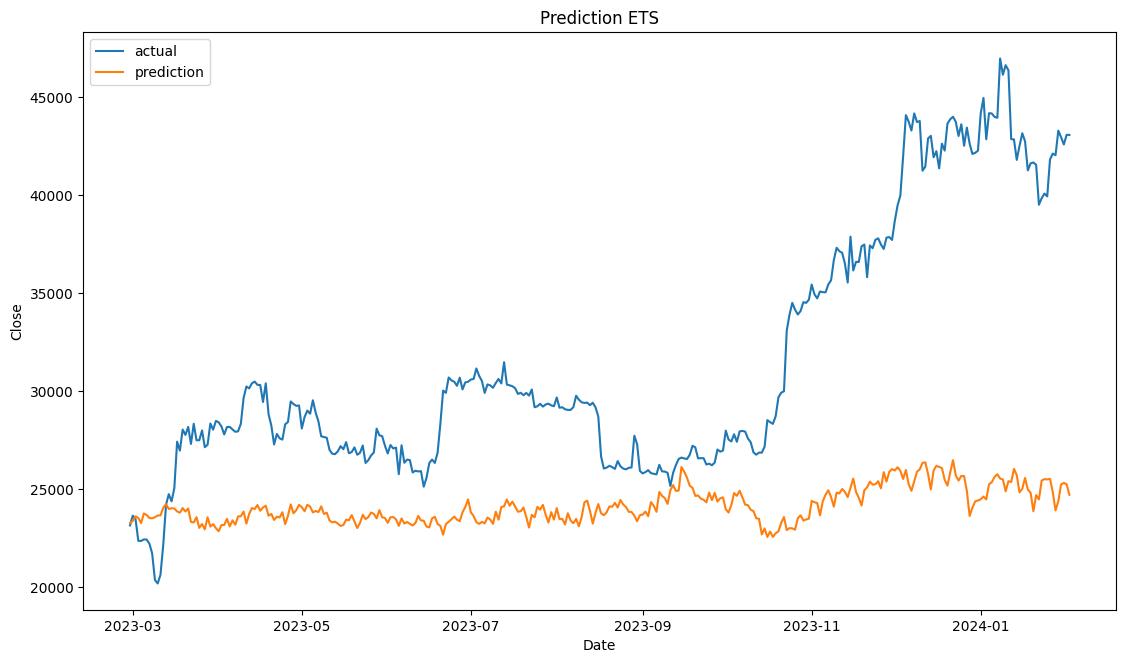

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.set_title("Prediction ETS")
ax.set_ylabel("Close")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [6]:
print_evaluation_metrics(p["prediction"], p[target_column], train[target_column])

Evaluation Metrics:
MSE: 86982098.83
RMSE: 9326.42
MAE: 7426.23
MAPE: 21.29
SMAPE: 24.84
MASE: 20.61


In [25]:
store_model(ets, "ets")

In [12]:
param_grid = {"global_trend_option": ["linear", "loglinear", "flat", "logistic"]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [14]:
global_trend_options = ["linear", "loglinear", "flat", "logistic"]

dlt_scores = dict()


def dlt_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an DLT model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return DLT(
        date_col=date_column,
        response_col=target_column,
        prediction_percentiles=[5, 95],
        regressor_col=["Closed_30_days_ago"],
        regressor_sign=["+"],
        regression_penalty="auto_ridge",
        damped_factor=0.8,
        seed=2,
        verbose=False,
        **ets_best_params,
        **grid
    )


with ThreadPoolExecutor(max_workers=4) as executor:
    futures = {
        executor.submit(
            evaluate_grid, dlt_function, option, train, date_column, target_column
        ): option
        for option in combinations_as_dicts
    }
    for future in concurrent.futures.as_completed(futures):
        option, score = future.result()
        dlt_scores[json.dumps(option)] = score

chain 1 |          | 00:00 Status









































































































































































































































































chain 1 |█████     | 04:02 Iteration:   1 / 250 [  0%]  (Warmup)










































































chain 1 |███████▌  | 04:29 Iteration: 100 / 250 [ 40%]  (Warmup)


chain 1 |██████████| 04:30 Sampling completed                     
chain 2 |██████████| 04:30 Sampling completed                     
chain 3 |██████████| 04:30 Sampling completed                     
chain 4 |██████████| 04:30 Sampling completed                     


chain 1 |██████████| 04:32 Iteration: 200 / 250 [ 80%]  (Warmup)

























































chain 1 |          | 04:35 Iteration: 226 / 250 [ 90%]  (Sampling)























































































































































chain 1 |██████████| 04:58 Sampling completed                     
chain 2 |██████████| 04:58 Sampling completed                     
chain 3 |██████████| 04:58 Sampling completed                     
chain 4 |██████████| 04:58 Sampling completed                     








chain 1 |          | 00:00 Status




















chain 1 |██▌       | 00:00 Status

















































































































chain 1 |██████████| 05:19 Sampling completed                     
chain 2 |██████████| 05:19 Sampling completed                     
chain 3 |██████████| 05:19 Sampling completed                     
chain 4 |██████████| 05:19 Sampling completed                     












chain 1 |██████████| 05:21 Sampling completed                     
chain 2 |██████████| 05:21 Sampling completed                     
chain 3 |██████████| 05:21 Sampling completed                     
chain 4 |██████████| 05:21 Sampling completed                     






















































































































































































































chain 1 |█████     | 03:40 Iteration:   1 / 250 [  0%]  (Warmup)


















chain 1 |██████████| 04:16 Sampling completed                     
chain 2 |██████████| 04:16 Sampling completed                     
chain 3 |██████████| 04:16 Sampling completed                     
chain 4 |██████████| 04:16 Sampling completed                     
















































































chain 1 |███████▌  | 04:05 Iteration: 100 / 250 [ 40%]  (Warmup)

chain 1 |██████████| 04:13 Iteration: 200 / 250 [ 80%]  (Warmup)






























chain 1 |          | 04:17 Iteration: 226 / 250 [ 90%]  (Sampling)












































chain 1 |██████████| 04:23 Sampling completed                     
chain 2 |██████████| 04:23 Sampling completed                     
chain 3 |██████████| 04:23 Sampling completed                     
chain 4 |██████████| 04:23 Sampling completed                     

chain 1 |          | 00:00 Status





































chain 1 |██▌       | 00:00 Status






























































































































































































chain 1 |██████████| 05:08 Sampling completed                     
chain 2 |██████████| 05:08 Sampling completed                     
chain 3 |██████████| 05:08 Sampling completed                     
chain 4 |██████████| 05:08 Sampling completed                     













chain 1 |██████████| 05:08 Sampling completed                     
chain 2 |██████████| 05:08 Sampling completed                     
chain 3 |██████████| 05:08 Sampling completed                     
chain 4 |██████████| 05:08 Sampling completed                     







































































































































































































































chain 1 |██████████| 04:14 Sampling completed                     
chain 2 |██████████| 04:14 Sampling completed                     
chain 3 |██████████| 04:14 Sampling completed                     
chain 4 |██████████| 04:14 Sampling completed                     





































































chain 1 |█████     | 03:50 Iteration:   1 / 250 [  0%]  (Warmup)








chain 1 |███████▌  | 04:27 Iteration: 100 / 250 [ 40%]  (Warmup)









chain 1 |██████████| 04:31 Iteration: 200 / 250 [ 80%]  (Warmup)

chain 1 |          | 04:35 Iteration: 226 / 250 [ 90%]  (Sampling)












































chain 1 |██████████| 05:03 Sampling completed                     
chain 2 |██████████| 05:03 Sampling completed                     
chain 3 |██████████| 05:03 Sampling completed                     
chain 4 |██████████| 05:03 Sampling completed                     












chain 1 |          | 00:00 Status

























chain 1 |██▌       | 00:00 Status






























































































































































































































chain 1 |██████████| 04:59 Sampling completed                     
chain 2 |██████████| 04:59 Sampling completed                     
chain 3 |██████████| 04:59 Sampling completed                     
chain 4 |██████████| 04:59 Sampling completed                     







chain 1 |██████████| 05:03 Sampling completed                     
chain 2 |██████████| 05:03 Sampling completed                     
chain 3 |██████████| 05:03 Sampling completed                     
chain 4 |██████████| 05:03 Sampling completed                     







































































































































































































































chain 1 |██████████| 04:23 Sampling completed                     
chain 2 |██████████| 04:23 Sampling completed                     
chain 3 |██████████| 04:23 Sampling completed                     
chain 4 |██████████| 04:23 Sampling completed                     














































































chain 1 |█████     | 04:24 Iteration:   1 / 250 [  0%]  (Warmup)
























































chain 1 |██████████| 04:58 Sampling completed                     
chain 2 |██████████| 04:58 Sampling completed                     
chain 3 |██████████| 04:58 Sampling completed                     
chain 4 |██████████| 04:58 Sampling completed                     

chain 1 |          | 00:00 Status


















chain 1 |██▌       | 00:00 Status








































































































































































chain 1 |██████████| 05:11 Sampling completed                     
chain 2 |██████████| 05:11 Sampling completed                     
chain 3 |██████████| 05:11 Sampling completed                     
chain 4 |██████████| 05:11 Sampling completed                     


















































































































chain 1 |██████████| 05:23 Sampling completed                     
chain 2 |██████████| 05:23 Sampling completed                     
chain 3 |██████████| 05:23 Sampling completed                     
chain 4 |██████████| 05:23 Sampling completed                     




































































































































































































chain 1 |██████████| 04:36 Sampling completed                     
chain 2 |██████████| 04:36 Sampling completed                     
chain 3 |██████████| 04:36 Sampling completed                     
chain 4 |██████████| 04:36 Sampling completed                     


















chain 1 |█████     | 03:37 Iteration:   1 / 250 [  0%]  (Warmup)













































chain 1 |███████▌  | 03:59 Iteration: 100 / 250 [ 40%]  (Warmup)






chain 1 |          | 04:05 Iteration: 226 / 250 [ 90%]  (Sampling)





chain 1 |██████████| 04:11 Sampling completed                     
chain 2 |██████████| 04:11 Sampling completed                     
chain 3 |██████████| 04:11 Sampling completed                     
chain 4 |██████████| 04:11 Sampling completed                     




































































chain 1 |██████████| 03:26 Sampling completed                     
chain 2 |██████████| 03:26 Sampling completed                     
chain 3 |██████████| 03:26 Sampling completed                     
chain 4 |██████████| 03:26 Sampling completed                     






















































































































































chain 1 |██████████| 03:19 Sampling completed                     
chain 2 |██████████| 03:19 Sampling completed                     
chain 3 |██████████| 03:19 Sampling completed                     
chain 4 |██████████| 03:19 Sampling completed                     

In [15]:
dlt_best_params = json.loads(min(dlt_scores, key=dlt_scores.get))
dlt_scores

{'{"global_trend_option": "flat"}': 1372.041392885059,
 '{"global_trend_option": "linear"}': 1374.1978307139425,
 '{"global_trend_option": "loglinear"}': 1384.9060707619565,
 '{"global_trend_option": "logistic"}': 1370.2493654016328}

In [4]:
dlt = DLT(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["Closed_30_days_ago"],
    regressor_sign=["+"],
    regression_penalty="auto_ridge",
    damped_factor=0.8,
    seed=2,
    verbose=False,
    **ets_best_params,
    **dlt_best_params
)

dlt.fit(train)

chain 1 |          | 00:00 Status











chain 1 |█████     | 01:05 Iteration:   1 / 250 [  0%]  (Warmup)


chain 1 |██████████| 01:11 Sampling completed                     
chain 2 |██████████| 01:11 Sampling completed                     
chain 3 |██████████| 01:11 Sampling completed                     
chain 4 |██████████| 01:11 Sampling completed                     

In [8]:
p = dlt.predict(df=test[[date_column, "Closed_30_days_ago"]])
p = p.merge(test, on=date_column, how="left")

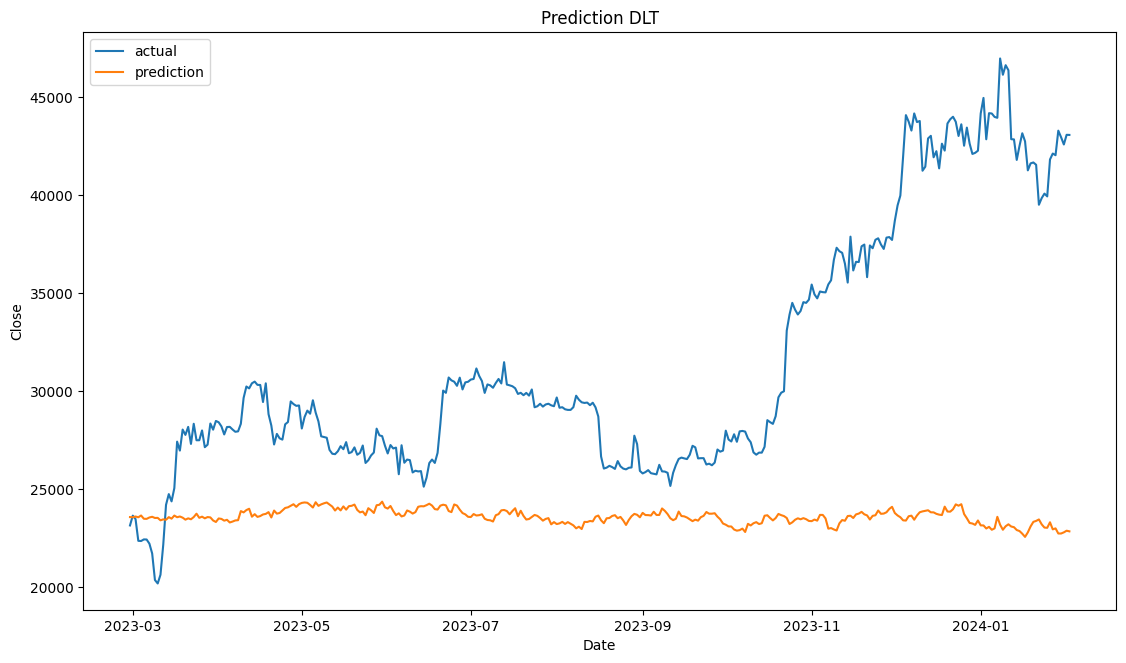

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.set_title("Prediction DLT")
ax.set_ylabel("Close")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [10]:
print_evaluation_metrics(p["prediction"], p[target_column], train[target_column])

Evaluation Metrics:
MSE: 103438666.30
RMSE: 10170.48
MAE: 7967.12
MAPE: 22.68
SMAPE: 26.92
MASE: 22.12


In [30]:
store_model(dlt, "dlt")

In [8]:
seasonality = [7, 30, 180, 360]

def all_possible_sublists(lst):
    n = len(lst)
    sublists = []
     
    for start in range(n):
        for end in range(start + 1, n + 1):
            sublists.append(lst[start:end])
     
    return sublists


sublists = all_possible_sublists(seasonality)
param_grid = {"seasonality": sublists, "seed": [1,2,3,4,5]}
param_values = list(param_grid.values())

all_combinations = list(itertools.product(*param_values))

combinations_as_dicts = [
    dict(zip(param_grid.keys(), combination)) for combination in all_combinations
]

In [13]:
ktr_scores = dict()


def ktr_function(grid: Dict[str, Any], date_column: str, target_column: str):
    """
    Create an DLT model with the specified parameters.

    Parameters:
    - grid (Dict[str, Any]): A dictionary containing the parameters for the ETS model.
    - date_column (str): The name of the date column.
    - target_column (str): The name of the target column.

    Returns:
    - An instance of the DLT model configured with the given parameters.
    """
    return KTR(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["Closed_30_days_ago"],
    verbose=False,
    **grid
)

for option in combinations_as_dicts:
    _, score = evaluate_grid(ktr_function, option, train, date_column, target_column)
    ktr_scores[json.dumps(option)] = score

2024-04-03 22:01:54 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-04-03 22:02:00 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-04-03 22:02:07 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-04-03 22:02:14 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-04-03 22:02:22 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-04-03 22:02:30 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-04-03 22:02:37 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.
2024-04-03 22:02:44 - orbit - INFO - Optimizing (PyStan) with 

In [14]:
ktr_best_params = json.loads(min(ktr_scores, key=ktr_scores.get))
ktr_best_params

{'seasonality': [7, 30, 180], 'seed': 2}

In [15]:
ktr = KTR(
    date_col=date_column,
    response_col=target_column,
    prediction_percentiles=[5, 95],
    regressor_col=["Closed_30_days_ago"],
    verbose=False,
    **ktr_best_params
)

ktr.fit(df=train)

2024-04-03 22:42:25 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
INFO:orbit:Optimizing (PyStan) with algorithm: LBFGS.


In [11]:
from shared.helpers import load_model
ktr = load_model("ktr")

Loading model_part1 in folder ../stored_models/ktr
Loading model_part2 in folder ../stored_models/ktr
Object loaded successfully.


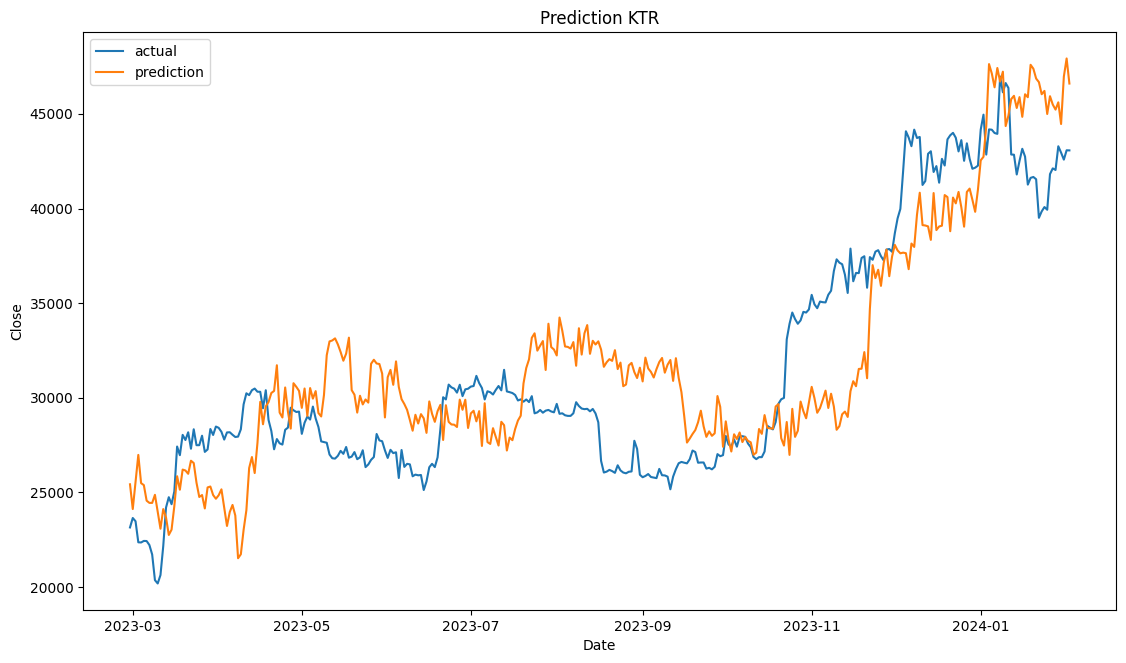

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(p[date_column], p[target_column], label="actual")
ax.plot(p[date_column], p["prediction"], label="prediction")
ax.set_title("Prediction KTR")
ax.set_ylabel("Close")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

In [14]:
print_evaluation_metrics(p["prediction"], p[target_column], train[target_column])

Evaluation Metrics:
MSE: 13768291.36
RMSE: 3710.56
MAE: 3188.89
MAPE: 10.41
SMAPE: 10.24
MASE: 8.85


In [35]:
store_model(ktr, "ktr")